# Introduction
XX.

```{thebe}
```

In [1]:
# %%
# jupyter: {'source_hidden': true}
import os
import sys
import re
import requests
import socket
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
from typing import List, Dict, Any, Optional, Union
import numpy as np
import geopandas as gpd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set up project paths
root_dir = Path.cwd().parent  # Assumes the notebook is inside a subfolder
data_dir = root_dir / 'data'
source_dir = data_dir / 'fsi-historic'

# Ensure project root is in the Python path
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# Import FCV utilities & style guide
from src.utils import (
    UCDP, GIC, ACLEDDataFetcher, RegionMapper, UNHCRDataFinder,
    WorldBankAPI, FSIDataProcessor, FragilityClassifier,
    RefugeeAnalyzer, UNPopulationDataPortalAPI
)

import fcv_style  # Automatically applies FCV styling

# Initialize data processors
ucdp = UCDP()
gic = GIC()
acled = ACLEDDataFetcher(api_key="FVlH2Cg6J1EmOKTxxsUX", email="mpurroyvitola@worldbank.org")
region_mapper = RegionMapper()
unhcr = UNHCRDataFinder()
wb = WorldBankAPI()



FCV Notebook Style Loaded.


# Conflict
## Number of Armed Conflicts by Type
XX.

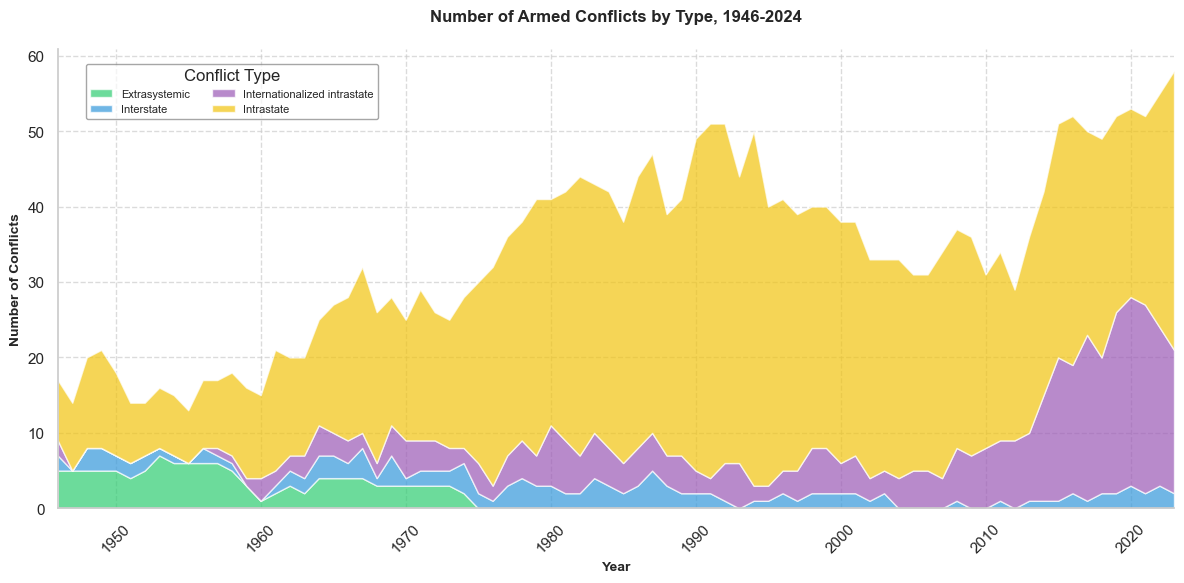

In [14]:
# %%
# jupyter: {'source_hidden': true}
# Fetch UCDP data
raw_data = ucdp.fetch_ucdp_data()
df_conflicts = ucdp.process_conflict_data(raw_data)
yearly_avg, decade_avg = ucdp.calculate_conflict_duration_panel(raw_data)

def create_conflict_plot(df, save_fig=False):
    """Create stacked area plot showing evolution of conflict types"""
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Get colors for each conflict type
    colors = [UCDP.get_conflict_colors()[col] for col in df.columns]
    
    # Create stacked area plot
    ax.stackplot(df.index, 
                [df[col] for col in df.columns],
                labels=df.columns,
                colors=colors,
                alpha=0.7)
    
    # Customize plot
    ax.set_xlabel('Year', fontsize=10, fontweight='bold')
    ax.set_ylabel('Number of Conflicts', fontsize=10, fontweight='bold')
    ax.set_title('Number of Armed Conflicts by Type, 1946-2024',
                fontsize=12, pad=20, fontweight='bold')
    
    # Set x-axis range
    ax.set_xlim(df.index.min(), df.index.max())
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add legend inside the plot with two columns
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(0.02, 0.98),
        ncol=2,
        fontsize=8,
        title='Conflict Type',
        frameon=True,
        facecolor='white',
        edgecolor='gray',
        framealpha=0.7
    )
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('conflict_evolution.png',
                    dpi=300,
                    bbox_inches='tight')
    
    return fig

# Create and display visualization
fig = create_conflict_plot(df_conflicts)
plt.show()


## Average duration of armed conflict worldwide, 1965-2024
XX.

2025-02-13 16:06:11,103 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-13 16:06:11,106 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


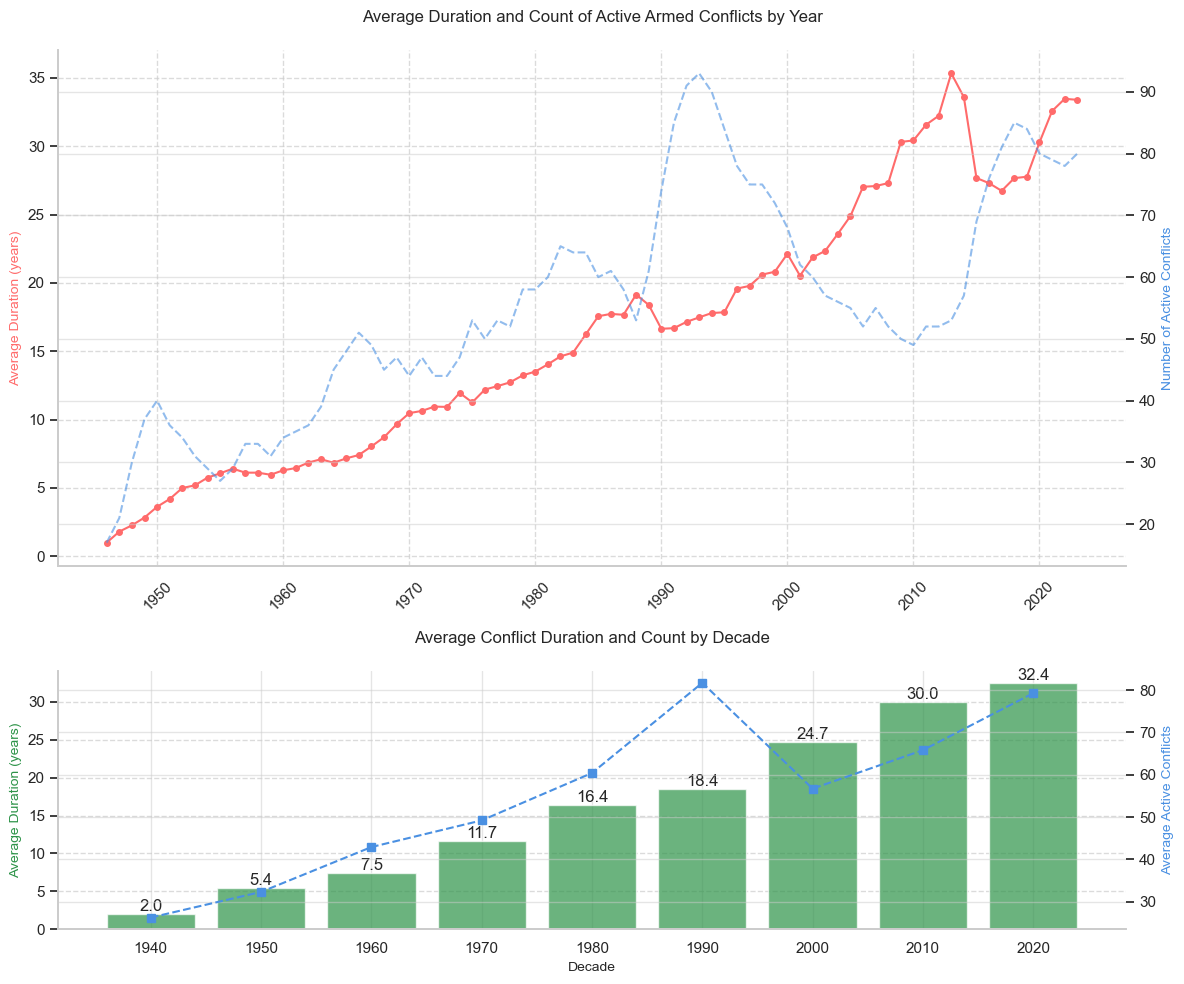

In [15]:
# %%
# jupyter: {'source_hidden': true}
def create_conflict_duration_plots(yearly_avg: pd.DataFrame, 
                                 decade_avg: pd.DataFrame, 
                                 save_fig: bool = False) -> plt.Figure:
    """
    Create visualization of conflict durations with yearly and decade views
    
    Parameters:
    -----------
    yearly_avg : pd.DataFrame
        DataFrame with yearly average durations
    decade_avg : pd.DataFrame
        DataFrame with decade averages
    save_fig : bool
        Whether to save the figure
        
    Returns:
    --------
    plt.Figure
        The generated figure object
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
    
    # Plot 1: Average duration line plot
    ax1.plot(yearly_avg['year'], yearly_avg['avg_duration'], 
            marker='o', linestyle='-', color='#FF6B6B', markersize=4)
    
    # Add number of conflicts as a second y-axis
    ax1_twin = ax1.twinx()
    ax1_twin.plot(yearly_avg['year'], yearly_avg['active_conflicts'],
                 color='#4A90E2', linestyle='--', alpha=0.6)
    
    # Customize the line plot
    ax1.set_xlabel('')
    ax1.set_ylabel('Average Duration (years)', color='#FF6B6B', fontsize=10)
    ax1_twin.set_ylabel('Number of Active Conflicts', color='#4A90E2', fontsize=10)
    ax1.set_title('Average Duration and Count of Active Armed Conflicts by Year', 
                 fontsize=12, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Decade averages bar plot
    bars = ax2.bar(decade_avg['decade'].astype(str), 
                  decade_avg['avg_duration'],
                  color='#2D9348', alpha=0.7)
    
    # Add decade average conflict counts
    ax2_twin = ax2.twinx()
    ax2_twin.plot(range(len(decade_avg)), decade_avg['active_conflicts'],
                 color='#4A90E2', marker='s', linestyle='--')
    
    # Customize the bar plot
    ax2.set_xlabel('Decade', fontsize=10)
    ax2.set_ylabel('Average Duration (years)', color='#2D9348', fontsize=10)
    ax2_twin.set_ylabel('Average Active Conflicts', color='#4A90E2', fontsize=10)
    ax2.set_title('Average Conflict Duration and Count by Decade', fontsize=12, pad=20)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('conflict_duration_panel.png', dpi=300, bbox_inches='tight')
    
    return fig

fig = create_conflict_duration_plots(yearly_avg, decade_avg)
plt.show()

## Conflict-induced fatalities by region (ACLED)
XX.

c:\Users\wb617270\OneDrive - WBG\FCV\slide-deck-analytics\docs\src\utils.py:924: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts = non_gang_data.groupby(['iso3', 'year', 'month', 'event_type']).size().unstack(fill_value=0)


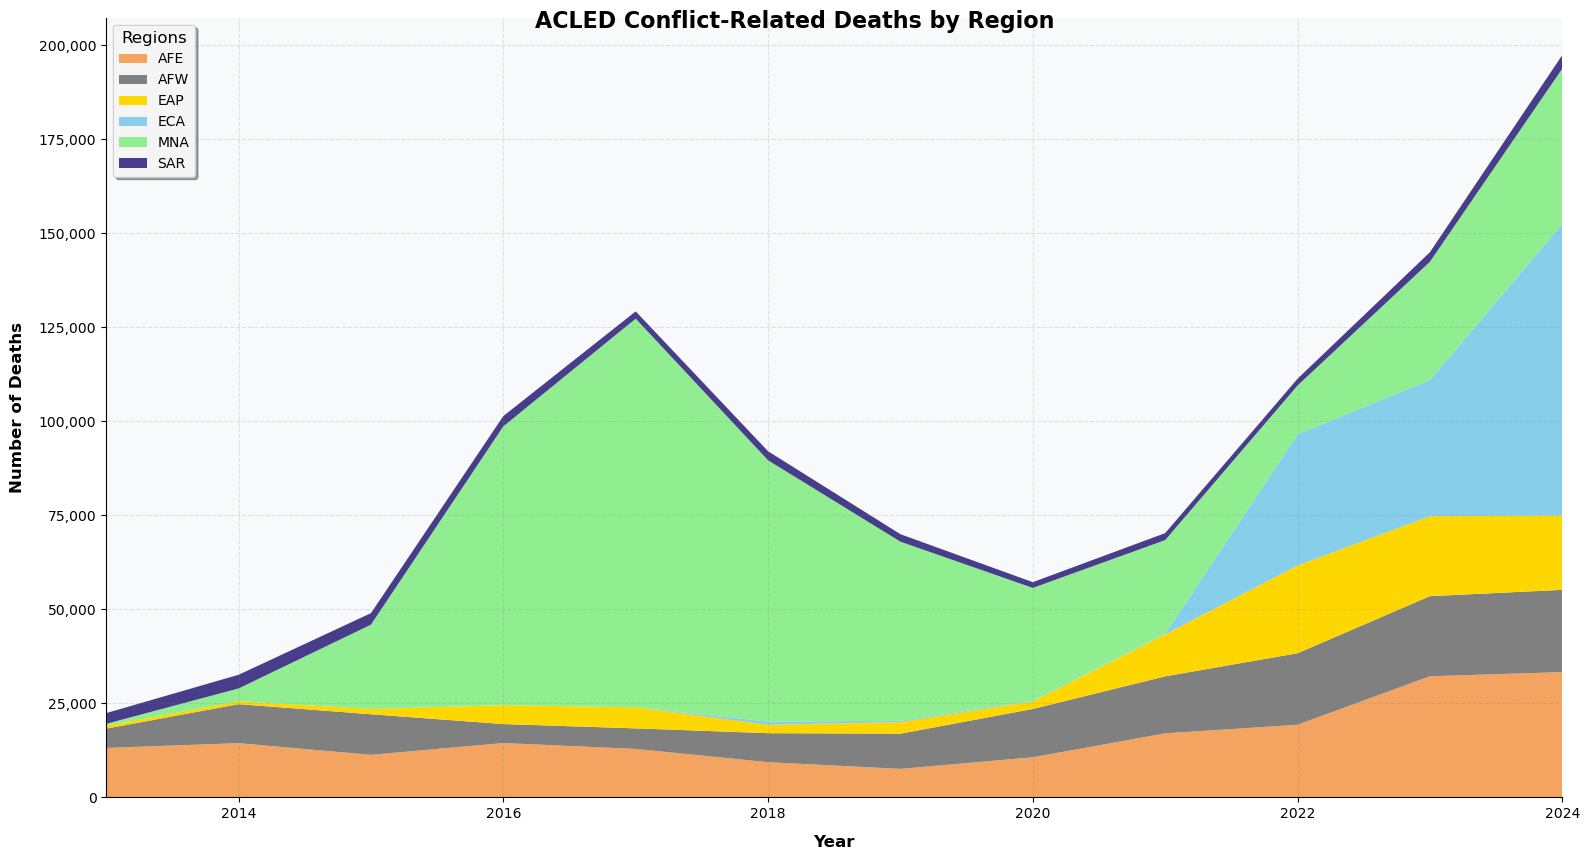

In [17]:
# %%
# jupyter: {'source_hidden': true}
# Initialize ACLED data fetcher
# Create date objects
start_date = datetime(2013, 1, 1)
end_date = datetime(2025, 1, 31)

# Fetch raw data
df_acled = acled.fetch_data(start_date, end_date)

# Process the data
df_acled_processed = acled.process_data(df_acled)

# Get conflict-related deaths if needed
df_acled_crd = acled.get_conflict_related_deaths(df_acled_processed)

# Get event counts if needed
df_acled_events = acled.get_event_counts(df_acled_processed)

def plot_acled_regional_deaths(df_acled_crd, region_mapper=None):
    """
    Create a stacked area plot of ACLED conflict-related deaths by region
    
    Parameters:
    -----------
    df_acled_crd : pd.DataFrame
        DataFrame with columns: iso3, year, month, ACLED_conflict_related_deaths
    region_mapper : RegionMapper, optional
        Region mapping object (default creates a simple one)
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import pycountry

    if region_mapper is None:
        region_mapper = RegionMapper()
    
    # Comprehensive region mapping
    region_mapping = {
        'AFE': [  # Eastern Africa
            'Kenya', 'Ethiopia', 'Uganda', 'Tanzania', 'Rwanda', 'Burundi', 
            'Somalia', 'South Sudan', 'Sudan', 'Eritrea', 'Djibouti'
        ],
        'AFW': [  # Western Africa
            'Nigeria', 'Ghana', 'Senegal', 'Mali', 'Burkina Faso', 'Guinea', 
            'Ivory Coast', 'Liberia', 'Sierra Leone', 'Togo', 'Benin', 'Niger', 
            'Gambia', 'Guinea-Bissau', 'Cape Verde'
        ],
        'EAP': [  # East Asia & Pacific
            'China', 'Japan', 'South Korea', 'Indonesia', 'Philippines', 'Vietnam', 
            'Thailand', 'Myanmar', 'Cambodia', 'Laos', 'Malaysia', 'Mongolia', 
            'Singapore', 'Papua New Guinea', 'Australia', 'New Zealand'
        ],
        'ECA': [  # Europe & Central Asia
            'Russia', 'Turkey', 'Ukraine', 'Kazakhstan', 'Uzbekistan', 'Georgia', 
            'Azerbaijan', 'Armenia', 'Moldova', 'Belarus', 'Poland', 'Romania', 
            'Bulgaria', 'Greece', 'Serbia', 'Croatia'
        ],
        'MNA': [  # Middle East & North Africa
            'Egypt', 'Iran', 'Iraq', 'Syria', 'Lebanon', 'Jordan', 'Palestine', 
            'Israel', 'Yemen', 'Saudi Arabia', 'United Arab Emirates', 'Algeria', 
            'Morocco', 'Tunisia', 'Libya', 'Bahrain', 'Kuwait', 'Oman', 'Qatar'
        ],
        'SAR': [  # South Asia
            'India', 'Pakistan', 'Bangladesh', 'Afghanistan', 'Nepal', 'Sri Lanka', 
            'Bhutan', 'Maldives'
        ]
    }
    
    def map_country_to_region(iso3):
        try:
            country_name = pycountry.countries.get(alpha_3=iso3).name
            for region, countries in region_mapping.items():
                if any(country.lower() in country_name.lower() for country in countries):
                    return region
            return 'Other'
        except (AttributeError, ValueError):
            return 'Other'
    
    # Create a copy and filter for years >= 2013
    df = df_acled_crd[df_acled_crd['year'] >= 2013].copy()
    
    # Add region column
    df['region'] = df['iso3'].apply(map_country_to_region)
    
    # Group by year and region, sum deaths
    yearly_region_deaths = df.groupby(['year', 'region'])['ACLED_conflict_related_deaths'].sum().unstack(fill_value=0)
    
    # Ensure all regions are present
    regions = ['AFE', 'AFW', 'EAP', 'ECA', 'MNA', 'SAR']
    for region in regions:
        if region not in yearly_region_deaths.columns:
            yearly_region_deaths[region] = 0
    
    # Select and order columns
    yearly_region_deaths = yearly_region_deaths[regions]
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Color palette
    colors = {
        'AFE': '#F4A460',   # Sandy Brown
        'AFW': '#808080',   # Gray
        'EAP': '#FFD700',   # Gold
        'ECA': '#87CEEB',   # Sky Blue
        'MNA': '#90EE90',   # Light Green
        'SAR': '#483D8B'    # Dark Slate Blue
    }
    
    # Plot stacked area
    ax.stackplot(yearly_region_deaths.index, 
                [yearly_region_deaths[region] for region in regions],
                labels=regions,
                colors=[colors[region] for region in regions])
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Add labels and title
    plt.suptitle('ACLED Conflict-Related Deaths by Region', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.title('',
             fontsize=12, style='italic', alpha=0.7, pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Deaths', fontsize=12, fontweight='bold', labelpad=10)
    
    # Set axis limits
    ax.set_xlim(2013, 2024)
    
    # Add legend with enhanced styling
    legend = ax.legend(title='Regions',
                      loc='upper left',
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10,
                      title_fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

# Create the plot
plot = plot_acled_regional_deaths(df_acled_crd)
plot.show()


## Conflict-induced fatalities by region including LAC (ACLED)
Most Latin American and Caribbean (LAC) countries were included in the ACLED dataset only after 2019. As a result, conflict event coverage for the region is limited in earlier years, and analyses involving historical trends should account for this data availability constraint..

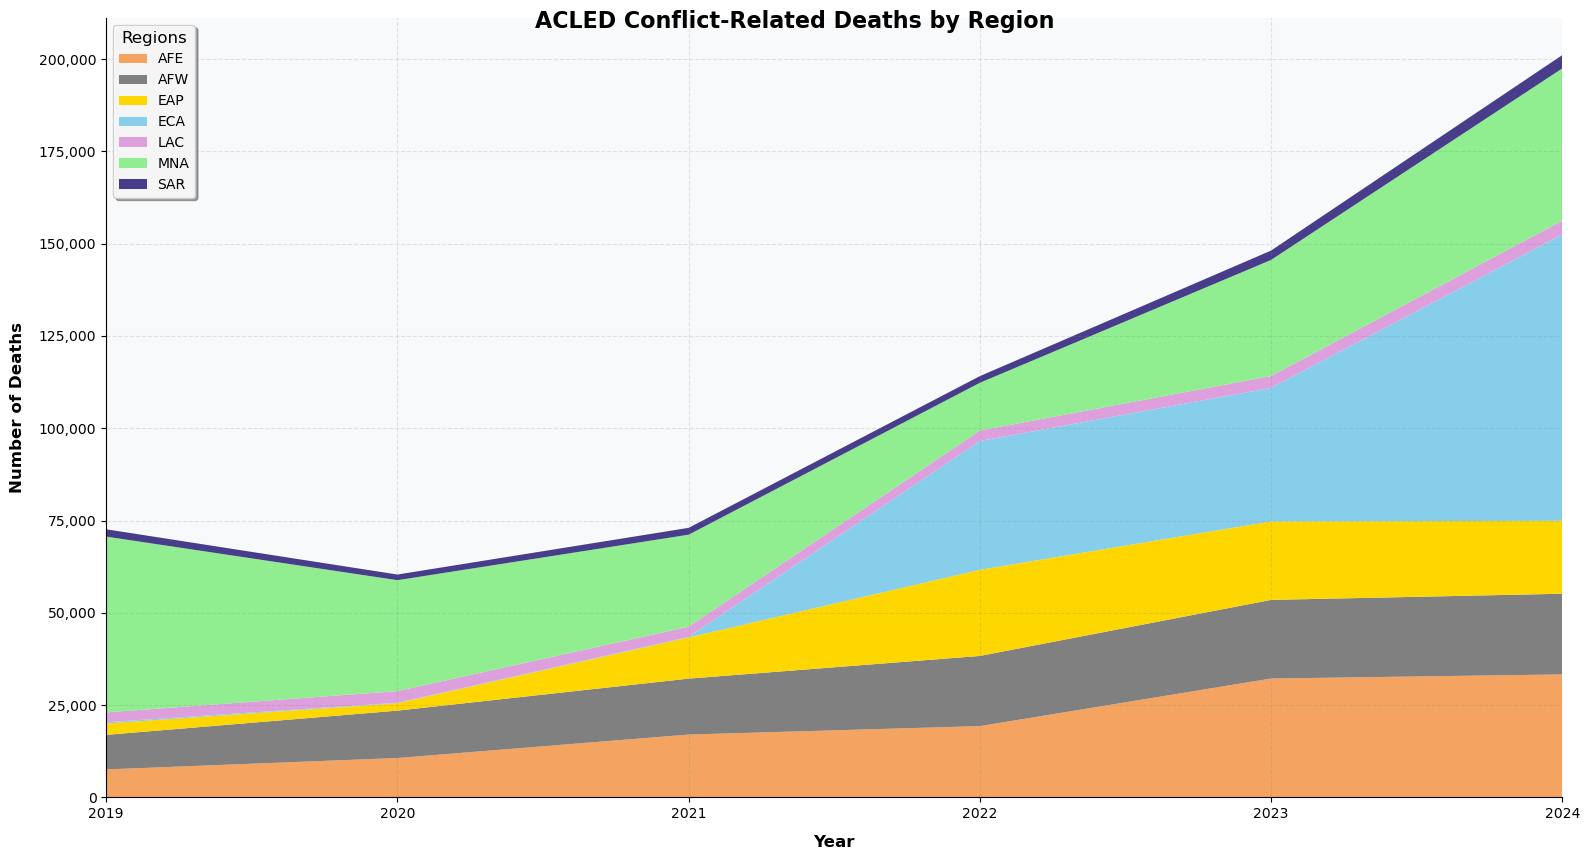

In [18]:
def plot_acled_regional_deaths_lac(df_acled_crd, region_mapper=None):
    """
    Create a stacked area plot of ACLED conflict-related deaths by region from 2019
    
    Parameters:
    -----------
    df_acled_crd : pd.DataFrame
        DataFrame with columns: iso3, year, month, ACLED_conflict_related_deaths
    region_mapper : RegionMapper, optional
        Region mapping object (default creates a simple one)
    """
    import pycountry
    import matplotlib.pyplot as plt

    if region_mapper is None:
        region_mapper = RegionMapper()
    
    # Comprehensive region mapping with LAC added
    region_mapping = {
        'AFE': [  # Eastern Africa
            'Kenya', 'Ethiopia', 'Uganda', 'Tanzania', 'Rwanda', 'Burundi', 
            'Somalia', 'South Sudan', 'Sudan', 'Eritrea', 'Djibouti'
        ],
        'AFW': [  # Western Africa
            'Nigeria', 'Ghana', 'Senegal', 'Mali', 'Burkina Faso', 'Guinea', 
            'Ivory Coast', 'Liberia', 'Sierra Leone', 'Togo', 'Benin', 'Niger', 
            'Gambia', 'Guinea-Bissau', 'Cape Verde'
        ],
        'EAP': [  # East Asia & Pacific
            'China', 'Japan', 'South Korea', 'Indonesia', 'Philippines', 'Vietnam', 
            'Thailand', 'Myanmar', 'Cambodia', 'Laos', 'Malaysia', 'Mongolia', 
            'Singapore', 'Papua New Guinea', 'Australia', 'New Zealand'
        ],
        'ECA': [  # Europe & Central Asia
            'Russia', 'Turkey', 'Ukraine', 'Kazakhstan', 'Uzbekistan', 'Georgia', 
            'Azerbaijan', 'Armenia', 'Moldova', 'Belarus', 'Poland', 'Romania', 
            'Bulgaria', 'Greece', 'Serbia', 'Croatia'
        ],
        'LAC': [  # Latin America & Caribbean
            'Brazil', 'Mexico', 'Colombia', 'Argentina', 'Peru', 'Venezuela', 
            'Chile', 'Ecuador', 'Bolivia', 'Paraguay', 'Uruguay', 'Cuba', 
            'Haiti', 'Dominican Republic', 'Jamaica', 'Trinidad and Tobago'
        ],
        'MNA': [  # Middle East & North Africa
            'Egypt', 'Iran', 'Iraq', 'Syria', 'Lebanon', 'Jordan', 'Palestine', 
            'Israel', 'Yemen', 'Saudi Arabia', 'United Arab Emirates', 'Algeria', 
            'Morocco', 'Tunisia', 'Libya', 'Bahrain', 'Kuwait', 'Oman', 'Qatar'
        ],
        'SAR': [  # South Asia
            'India', 'Pakistan', 'Bangladesh', 'Afghanistan', 'Nepal', 'Sri Lanka', 
            'Bhutan', 'Maldives'
        ]
    }
    
    def map_country_to_region(iso3):
        try:
            country_name = pycountry.countries.get(alpha_3=iso3).name
            for region, countries in region_mapping.items():
                if any(country.lower() in country_name.lower() for country in countries):
                    return region
            return 'Other'
        except (AttributeError, ValueError):
            return 'Other'
    
    # Create a copy and filter for years >= 2019
    df = df_acled_crd[df_acled_crd['year'] >= 2019].copy()
    
    # Add region column
    df['region'] = df['iso3'].apply(map_country_to_region)
    
    # Group by year and region, sum deaths
    yearly_region_deaths = df.groupby(['year', 'region'])['ACLED_conflict_related_deaths'].sum().unstack(fill_value=0)
    
    # Ensure all regions are present
    regions = ['AFE', 'AFW', 'EAP', 'ECA', 'LAC', 'MNA', 'SAR']
    for region in regions:
        if region not in yearly_region_deaths.columns:
            yearly_region_deaths[region] = 0
    
    # Select and order columns
    yearly_region_deaths = yearly_region_deaths[regions]
    
    # Create the plot with enhanced styling
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Enhanced color palette
    colors = {
        'AFE': '#F4A460',   # Sandy Brown
        'AFW': '#808080',   # Gray
        'EAP': '#FFD700',   # Gold
        'ECA': '#87CEEB',   # Sky Blue
        'LAC': '#DDA0DD',   # Plum
        'MNA': '#90EE90',   # Light Green
        'SAR': '#483D8B'    # Dark Slate Blue
    }
    
    # Plot stacked area
    ax.stackplot(yearly_region_deaths.index, 
                [yearly_region_deaths[region] for region in regions],
                labels=regions,
                colors=[colors[region] for region in regions])
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Add labels and title
    plt.suptitle('ACLED Conflict-Related Deaths by Region', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.title('',
             fontsize=12, style='italic', alpha=0.7, pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Deaths', fontsize=12, fontweight='bold', labelpad=10)
    
    # Set axis limits
    ax.set_xlim(2019, 2024)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add legend with enhanced styling
    legend = ax.legend(title='Regions',
                      loc='upper left',
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10,
                      title_fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    plt.tight_layout()
    
    return plt

# Create the plot
plot = plot_acled_regional_deaths_lac(df_acled_crd)
plot.show()

## Conflict-induced fatalities by income (ACLED)


Total conflict-related deaths (2013-2024): 1,190,619

Distribution by income group:
High income: 13,358 deaths (1.1%)
Upper middle income: 283,870 deaths (23.8%)
Lower middle income: 300,919 deaths (25.3%)
Low income: 586,505 deaths (49.3%)
Not classified: 5,967 deaths (0.5%)


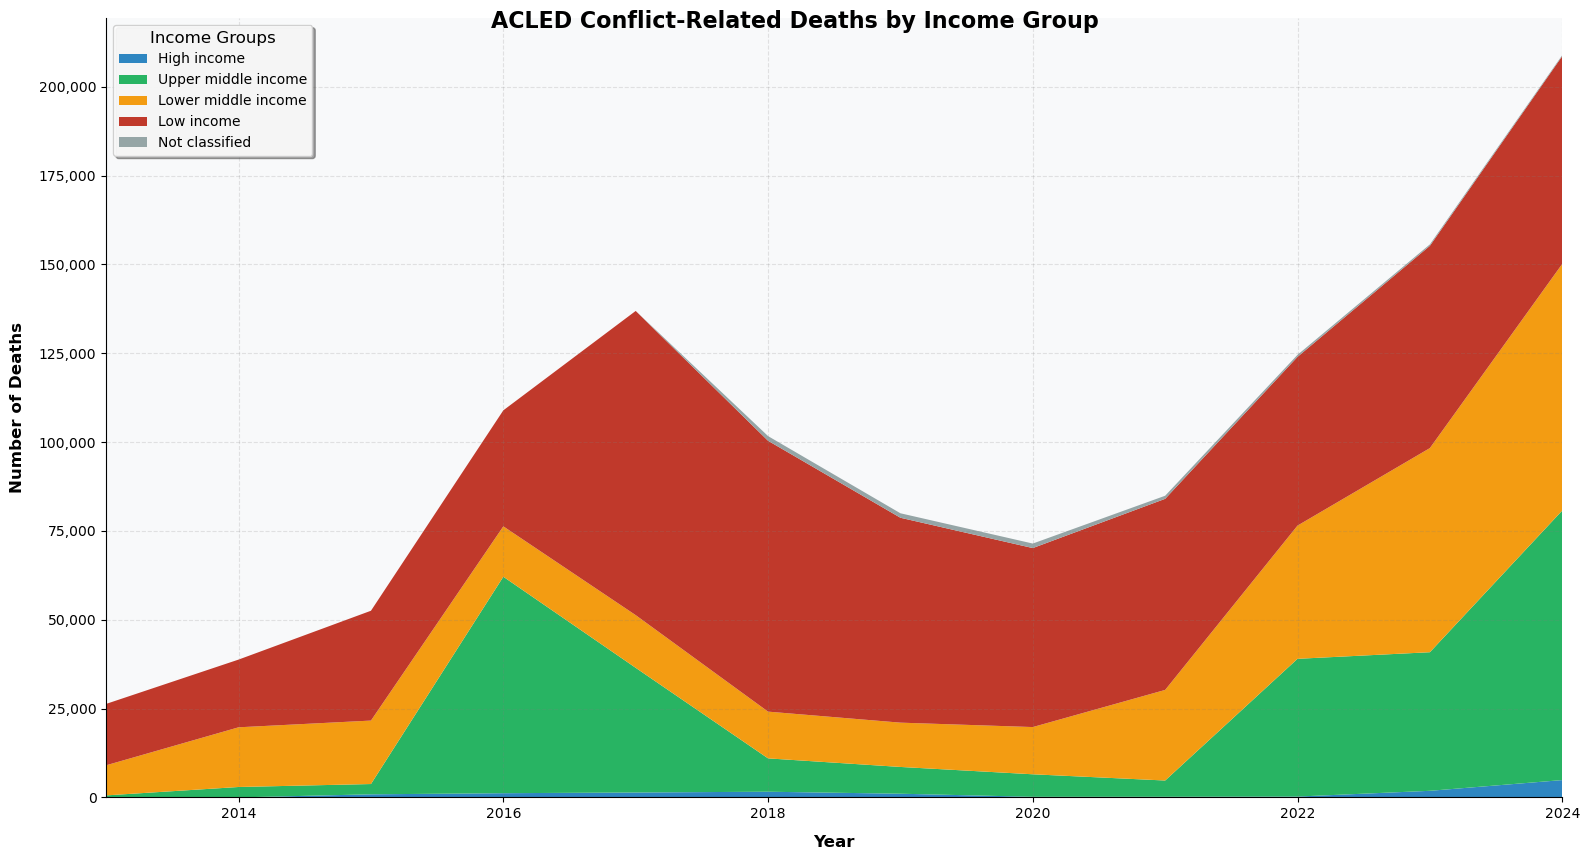

In [19]:
lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')

def plot_acled_income_deaths(df_acled_crd, lend_group_path):
    """
    Create a stacked area plot of ACLED conflict-related deaths by income group
    
    Parameters:
    -----------
    df_acled_crd : pd.DataFrame
        DataFrame with columns: iso3, year, month, ACLED_conflict_related_deaths
    lend_group_path : str
        Path to the lending group Excel file
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Read lending group data
    lend_group = pd.read_excel(lend_group_path)
    
    # Create a copy of the DataFrame
    df = df_acled_crd.copy()
    
    # Merge with lending group data
    df = df.merge(lend_group[['Code', 'Income group']], 
                 left_on='iso3', 
                 right_on='Code', 
                 how='left')
    
    # Fill missing income groups
    df['Income group'] = df['Income group'].fillna('Not classified')
    
    # Group by year and income group, sum deaths
    yearly_income_deaths = df.groupby(
        ['year', 'Income group'])['ACLED_conflict_related_deaths'].sum().unstack(fill_value=0)
    
    # Define income groups in desired order
    income_groups = [
        'High income',
        'Upper middle income',
        'Lower middle income',
        'Low income',
        'Not classified'
    ]
    
    # Ensure all income groups are present
    for group in income_groups:
        if group not in yearly_income_deaths.columns:
            yearly_income_deaths[group] = 0
    
    # Select and order columns
    yearly_income_deaths = yearly_income_deaths[income_groups]
    
    # Filter for years 2013-2024
    yearly_income_deaths = yearly_income_deaths.loc[2013:2024]
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Color palette for income groups
    colors = {
        'High income': '#2E86C1',        # Blue
        'Upper middle income': '#28B463', # Green
        'Lower middle income': '#F39C12', # Orange
        'Low income': '#C0392B',         # Red
        'Not classified': '#95A5A6'       # Gray
    }
    
    # Plot stacked area
    ax.stackplot(yearly_income_deaths.index, 
                [yearly_income_deaths[group] for group in income_groups],
                labels=income_groups,
                colors=[colors[group] for group in income_groups])
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Add labels and title
    plt.suptitle('ACLED Conflict-Related Deaths by Income Group', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.title('',
             fontsize=12, style='italic', alpha=0.7, pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Deaths', fontsize=12, fontweight='bold', labelpad=10)
    
    # Set axis limits
    ax.set_xlim(2013, 2024)
    
    # Add legend with enhanced styling
    legend = ax.legend(title='Income Groups',
                      loc='upper left',
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10,
                      title_fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Calculate and print summary statistics
    total_deaths = yearly_income_deaths.sum().sum()
    print(f"\nTotal conflict-related deaths (2013-2024): {total_deaths:,.0f}")
    
    print("\nDistribution by income group:")
    for group in income_groups:
        group_total = yearly_income_deaths[group].sum()
        percentage = (group_total / total_deaths) * 100
        print(f"{group}: {group_total:,.0f} deaths ({percentage:.1f}%)")
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

plot = plot_acled_income_deaths(df_acled_crd, lend_group_path)
plot.show()

## Conflict-induced fatalities by type of conflict (UCDP)
XX.

C:\Users\wb617270\AppData\Local\Temp\ipykernel_28472\3306066592.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


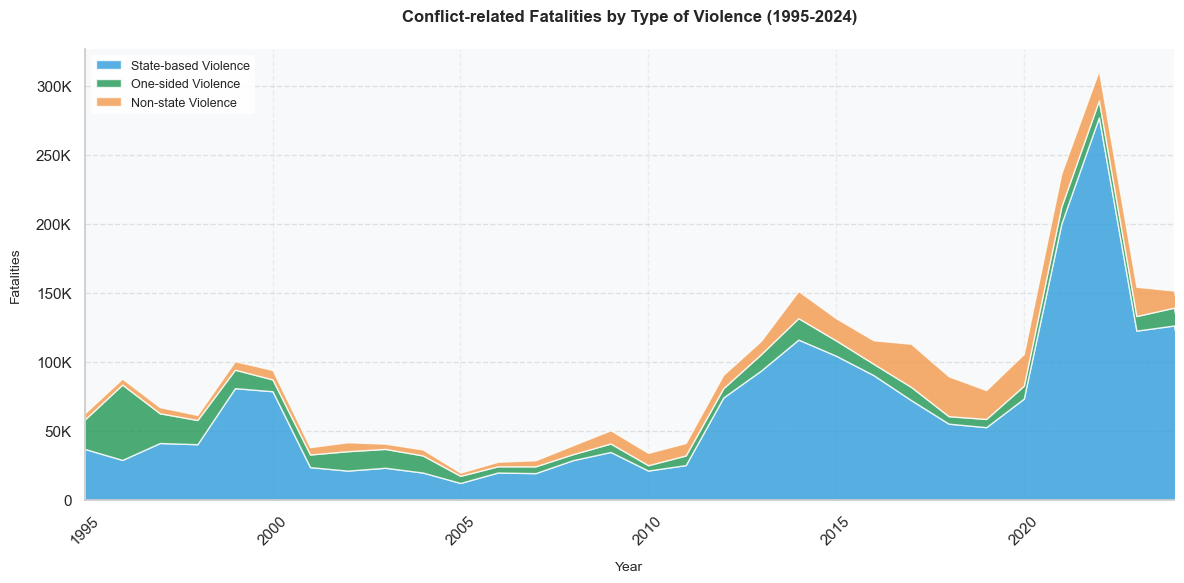

In [6]:
# %%
# jupyter: {'source_hidden': true}
# Fetch fatalities data for a specific period
# fatalities_df = ucdp.fetch_fatalities_data(
#     start_date='1995-11-01',
#     end_date='2024-12-31'
# )
# df_fat = ucdp.process_fatalities_data(fatalities_df) 

import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

def plot_ucdp_fatalities(df: pd.DataFrame, 
                          output_path: Optional[str] = None) -> plt.Figure:
    """
    Create a stacked area plot of fatalities by violence type using UCDP data
    
    Parameters:
    -----------
    df : pd.DataFrame
        Processed UCDP fatalities data 
    output_path : str, optional
        If provided, save the plot to this path
        
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    # Filter data from 1995 onwards
    df = df[df.index >= 1995]
    
    # Create the figure with higher resolution
    fig = plt.figure(figsize=(12, 6), dpi=100)
    
    # Extract data for each violence type
    years = df.index
    state_based = df['UCDP_BRD_state_based']
    one_sided = df['UCDP_BRD_one_sided']
    non_state = df['UCDP_BRD_non_state']
    
    # Create stacked area plot with enhanced colors and alpha
    plt.stackplot(years, 
                 [state_based, one_sided, non_state],
                 labels=['State-based Violence', 'One-sided Violence', 'Non-state Violence'],
                 colors=['#2D9CDB', '#219653', '#F2994A'],  # Blue, Green, Orange
                 alpha=0.8)
    
    # Customize the plot
    plt.xlabel('Year', fontsize=10, labelpad=10)
    plt.ylabel('Fatalities', fontsize=10, labelpad=10)
    
    # Format y-axis with thousands
    def format_func(x, p):
        if x >= 1000000:
            return f'{x/1000000:.1f}M'
        elif x >= 1000:
            return f'{x/1000:.0f}K'
        else:
            return f'{int(x):,}'
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
    # Enhance grid
    plt.grid(axis='y', linestyle='--', alpha=0.2, color='gray')
    plt.grid(axis='x', linestyle='--', alpha=0.1, color='gray')
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Customize legend
    plt.legend(loc='upper left', frameon=True, framealpha=0.9, 
              facecolor='white', edgecolor='none', fontsize=9)
    
    # Add title
    plt.title('Conflict-related Fatalities by Type of Violence (1995-2024)', 
             pad=20, fontsize=12, fontweight='bold')
    
    # Set x-axis limits to full years
    plt.xlim(min(years), 2024)
    
    # Rotate x-axis labels slightly for better readability
    plt.xticks(rotation=45)
    
    # Add subtle background color
    plt.gca().set_facecolor('#f8f9fa')
    plt.gcf().patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300, 
                   facecolor='white', edgecolor='none')
        print(f"Plot saved to {output_path}")
    
    return fig

def prepare_ucdp_fatalities_data(data_dir: str):
    """
    Prepare UCDP fatalities data for plotting
    
    Parameters:
    -----------
    data_dir : str
        Directory containing the UCDP data file
    
    Returns:
    --------
    pd.DataFrame
        Processed UCDP fatalities data aggregated by year
    """
    # Construct file path
    ucdp_path = os.path.join(data_dir, 'ucdp.csv')
    
    # Read data
    df = pd.read_csv(ucdp_path)
    
    # Group by year and sum fatalities
    yearly_fatalities = df.groupby('year').agg({
        'UCDP_BRD_state_based': 'sum',
        'UCDP_BRD_non_state': 'sum',
        'UCDP_BRD_one_sided': 'sum'
    }).reset_index()
    
    # Set year as index
    yearly_fatalities.set_index('year', inplace=True)
    
    return yearly_fatalities


df_fat = prepare_ucdp_fatalities_data(data_dir)
plot = plot_ucdp_fatalities(df_fat)
plot.show()

## UCDP by income group
XX.

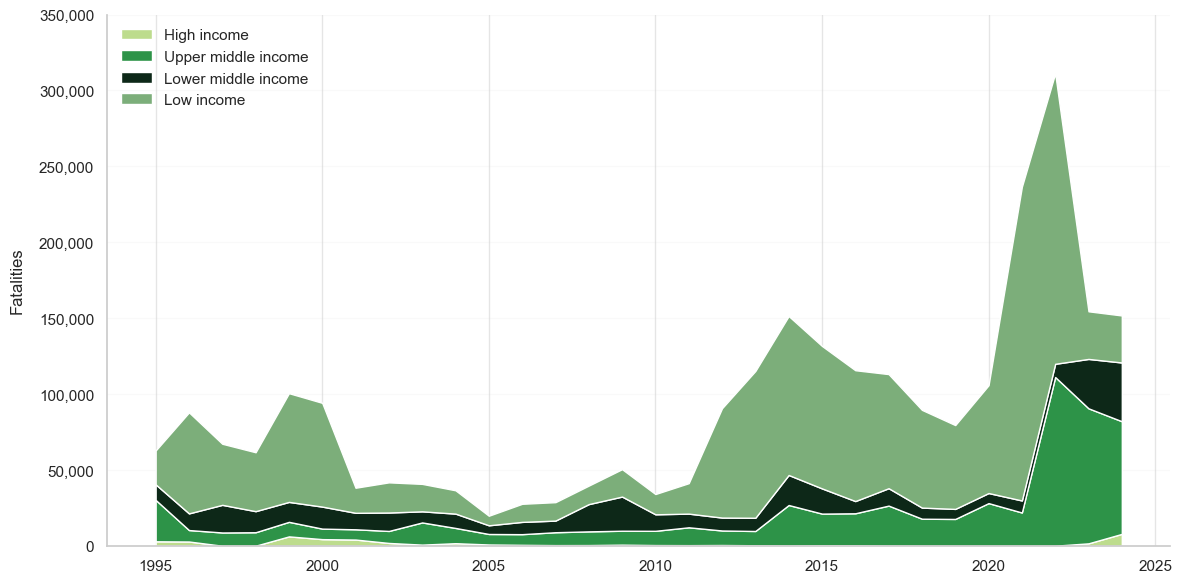

In [7]:
# %%
# jupyter: {'source_hidden': true}
def plot_fatalities_by_income(data_dir: str):
    """
    Create a stacked area plot of total fatalities by income group
    
    Parameters:
    -----------
    data_dir : str
        Directory containing both UCDP and lending group data
    """
    # Construct file paths
    ucdp_path = os.path.join(data_dir, 'ucdp.csv')
    lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')
    
    # Read data
    ucdp = pd.read_csv(ucdp_path, usecols=['iso3', 'year', 'UCDP_BRD'])
    lend_group = pd.read_excel(lend_group_path)
    
    # Merge datasets
    df = ucdp.merge(lend_group[['Code', 'Income group']], 
                    left_on='iso3', 
                    right_on='Code', 
                    how='left')
    
    # Group by year and income group, sum fatalities
    yearly_fatalities = df.groupby(['year', 'Income group'])['UCDP_BRD'].sum().reset_index()
    
    # Pivot data for plotting
    fatalities_pivot = yearly_fatalities.pivot(
        index='year',
        columns='Income group',
        values='UCDP_BRD'
    )
    
    # Create the figure
    plt.figure(figsize=(12, 6))
    
    # Filter years between 1995 and 2024
    fatalities_pivot = fatalities_pivot[(fatalities_pivot.index >= 1995) & (fatalities_pivot.index < 2025)]
    years = fatalities_pivot.index
    income_groups = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
    
    # Filter and reorder columns based on income groups that exist in the data
    available_groups = [group for group in income_groups if group in fatalities_pivot.columns]
    fatalities_data = [fatalities_pivot[group].fillna(0) for group in available_groups]
    
    # Define colors for income groups
    colors = ['#BDDC8D', '#2D9348', '#0D2818', '#7CAE7A']  # Light green to dark green
    
    # Create stacked area plot
    plt.stackplot(years, 
                 fatalities_data,
                 labels=available_groups,
                 colors=colors[:len(available_groups)])
    
    # Customize the plot
    plt.xlabel('')
    plt.ylabel('Fatalities', rotation=90, labelpad=10)
    
    # Format y-axis with thousands
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Add thousands separator to y-axis labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticks(current_values)
    
    # Customize grid (only horizontal lines)
    plt.grid(axis='y', linestyle='-', alpha=0.1)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Customize legend
    plt.legend(loc='upper left', frameon=False)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

plot = plot_fatalities_by_income(data_dir)
plot.show()

# Coups
## Global Coup Attempts
XX.

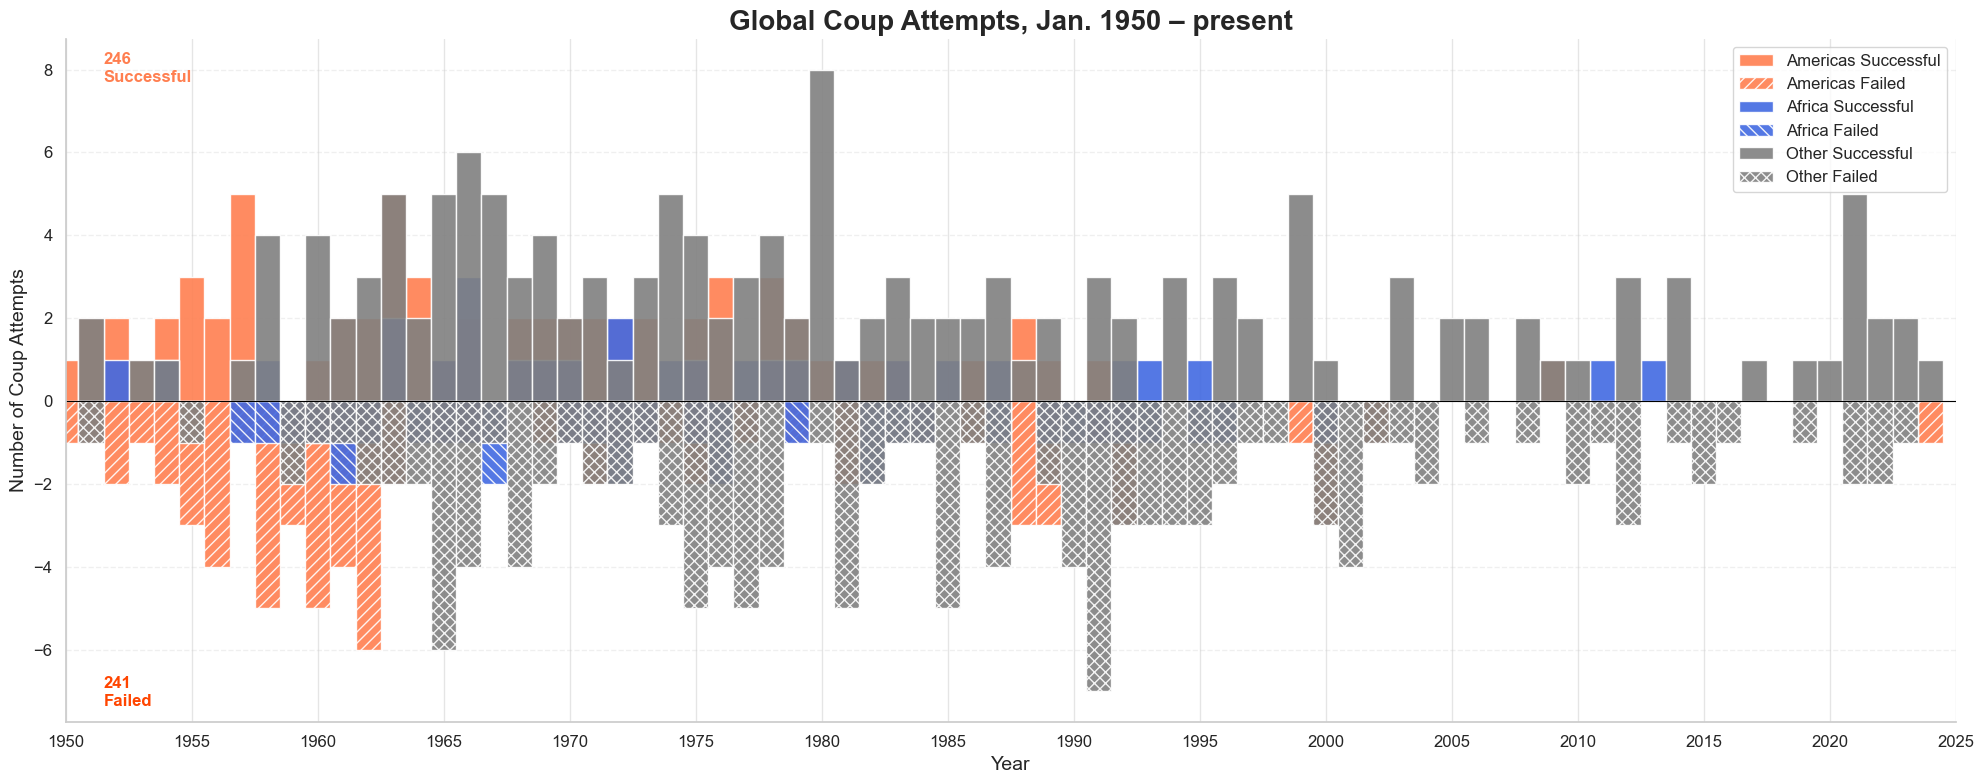

In [8]:
# %%
# jupyter: {'source_hidden': true}
# # Fetch GIC data
df_gic = gic.processed_data

def plot_global_coup_attempts(data, start_year=1950, end_year=2025):
    """
    Create a visualization of global coup attempts with patterns for failed coups
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Processed coup data 
    start_year : int, optional
        Starting year for the plot (default is 1950)
    end_year : int, optional
        Ending year for the plot to nowadays
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(20, 8), dpi=100)
    
    # Filter data for specified year range
    plot_data = data[
        (data['year'] >= start_year) & 
        (data['year'] <= end_year)
    ]
    
    # Group data by year, region, and coup status
    yearly_data = plot_data.groupby(['year', 'region', 'coup_status']).size().reset_index(name='count')
    
    # Color palette and hatch patterns
    colors = {
        ('Americas', 2): '#FF7F50',   # Coral for successful Americas coups
        ('Americas', 1): '#FF7F50',   # Same color for failed but with pattern
        ('Africa', 2): '#4169E1',     # Royal blue for successful Africa coups
        ('Africa', 1): '#4169E1',     # Same color for failed but with pattern
        ('Other', 2): '#808080',      # Gray for successful Other coups
        ('Other', 1): '#808080'       # Same color for failed but with pattern
    }
    
    # Hatch patterns for failed coups
    hatches = {
        'Americas': '///',
        'Africa': '\\\\\\',
        'Other': 'xxx'
    }
    
    # Regions to plot
    regions = ['Americas', 'Africa', 'Other']
    
    # Plot each region's coups
    for region in regions:
        region_data = yearly_data[yearly_data['region'] == region]
        
        # Successful coups (above zero)
        successful = region_data[region_data['coup_status'] == 2]
        for _, row in successful.iterrows():
            ax.bar(row['year'], row['count'], 
                  color=colors.get((region, 2)), 
                  alpha=0.9, 
                  width=1, 
                  label=f'{region} Successful' if row['year'] == successful.iloc[0]['year'] else "")
        
        # Failed coups (below zero)
        failed = region_data[region_data['coup_status'] == 1]
        for _, row in failed.iterrows():
            ax.bar(row['year'], -row['count'], 
                  color=colors.get((region, 1)), 
                  alpha=0.9, 
                  width=1,
                  hatch=hatches[region],
                  label=f'{region} Failed' if row['year'] == failed.iloc[0]['year'] else "")
    
    # Styling
    ax.set_title('Global Coup Attempts, Jan. 1950 – present', fontsize=20, fontweight='bold')
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of Coup Attempts', fontsize=14)
    
    # X-axis setup
    ax.set_xlim(start_year, end_year)
    ax.set_xticks(np.arange(start_year, end_year+1, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Zero line
    ax.axhline(y=0, color='black', linewidth=0.8)
    
    # Total coup annotations
    successful_total = yearly_data[yearly_data['coup_status'] == 2]['count'].sum()
    failed_total = yearly_data[yearly_data['coup_status'] == 1]['count'].sum()
    
    ax.text(0.02, 0.98, f'{successful_total}\nSuccessful', transform=ax.transAxes, 
            verticalalignment='top', fontsize=12, fontweight='bold', color='#FF7F50')
    ax.text(0.02, 0.02, f'{failed_total}\nFailed', transform=ax.transAxes, 
            verticalalignment='bottom', fontsize=12, fontweight='bold', color='#FF4500')
    
    # Add legend with custom ordering
    handles, labels = ax.get_legend_handles_labels()
    # Reorder to group by region
    order = ['Americas Successful', 'Americas Failed',
             'Africa Successful', 'Africa Failed',
             'Other Successful', 'Other Failed']
    ordered_handles = []
    ordered_labels = []
    for label in order:
        idx = labels.index(label)
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels[idx])
    
    ax.legend(ordered_handles, ordered_labels, 
             loc='upper right', 
             fontsize=12, 
             frameon=True)
    
    plt.tight_layout()
    return plt

# Example usage
if __name__ == '__main__':
    plt = plot_global_coup_attempts(df_gic)
    plt.show()

# Displacement
## Forcibly Displaced Persons
XX.

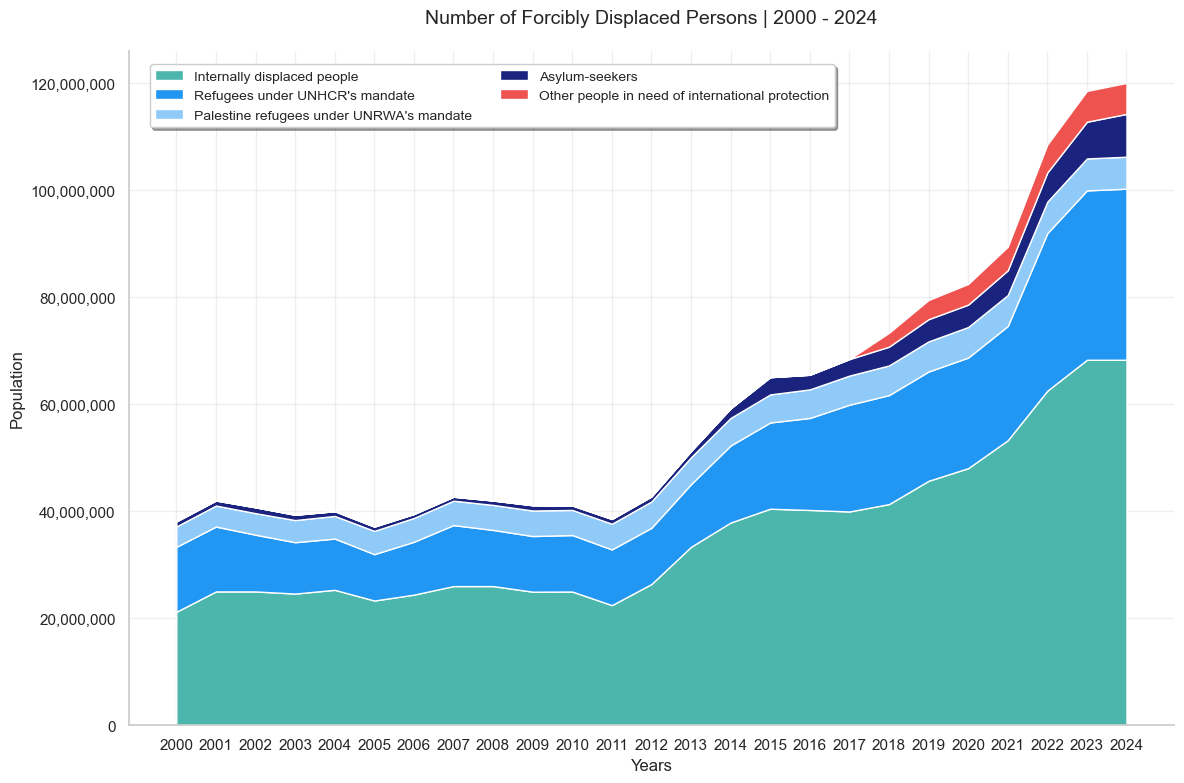

In [9]:
# %%
# jupyter: {'source_hidden': true}
# Get processed data suitable for visualization
def prepare_data_for_plotting(df_unchr):
    """
    Prepare the data for plotting by ensuring correct types and handling missing values
    
    Parameters:
    -----------
    df_unchr : pd.DataFrame
        Input DataFrame from UNHCR data
        
    Returns:
    --------
    pd.DataFrame
        Processed DataFrame ready for plotting
    """
    # List of columns that should be numeric
    numeric_cols = ['refugees_unhcr', 'asylum_seekers', 'other_protection', 
                   'refugees_unrwa', 'idps']
    
    # Create a copy to avoid modifying the original
    plot_df = df_unchr.copy()
    
    # Convert numeric columns and replace '-' with 0
    for col in numeric_cols:
        # Replace '-' with 0
        if col in plot_df.columns:
            plot_df[col] = plot_df[col].replace('-', 0)
            # Convert to numeric, replacing errors with 0
            plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce').fillna(0)
    
    return plot_df

def plot_forced_displacement(df_input, output_path=None):
    """
    Create a stacked area plot of forced displacement data
    
    Parameters:
    -----------
    df_input : pd.DataFrame
        DataFrame containing columns: year, refugees_unhcr, asylum_seekers,
        other_protection, refugees_unrwa, idps
    output_path : str, optional
        If provided, save the plot to this path
    """
    # Prepare data
    plot_df = prepare_data_for_plotting(df_input)
    
    # Create the figure with specified size and extra space for legend
    plt.figure(figsize=(12, 8))
    
    # Get the years for x-axis
    years = plot_df['year']
    
    # Prepare the data arrays
    idps = plot_df['idps'].values
    refugees_unhcr = plot_df['refugees_unhcr'].values
    refugees_unrwa = plot_df['refugees_unrwa'].values
    asylum_seekers = plot_df['asylum_seekers'].values
    other_protection = plot_df['other_protection'].values
    
    # Create stacked area plot
    plt.stackplot(years,
                 [idps, refugees_unhcr, refugees_unrwa, asylum_seekers, other_protection],
                 labels=['Internally displaced people',
                        'Refugees under UNHCR\'s mandate',
                        'Palestine refugees under UNRWA\'s mandate',
                        'Asylum-seekers',
                        'Other people in need of international protection'],
                 colors=['#4DB6AC',    # Turquoise for IDPs
                        '#2196F3',     # Blue for UNHCR refugees
                        '#90CAF9',     # Light blue for UNRWA refugees
                        '#1A237E',     # Dark blue for asylum seekers
                        '#EF5350'])    # Red for other protection
    
    # Customize the plot
    plt.title('Number of Forcibly Displaced Persons | 2000 - 2024', 
              fontsize=14, pad=20)
    plt.xlabel('Years', fontsize=12)
    plt.ylabel('Population', fontsize=12)
    
    # Format y-axis with millions
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Set x-axis ticks to show all years
    plt.xticks(years, rotation=0)
    
    # Customize grid
    plt.grid(True, alpha=0.3)
    
    # Position legend inside the plot at top left corner
    plt.legend(loc='upper left',
              bbox_to_anchor=(0.02, 0.98),  # Fixed position at top left
              ncol=2,  # 2 columns
              borderaxespad=0,
              frameon=True,  # Add frame around legend
              fancybox=True,  # Rounded corners
              shadow=True,    # Add shadow
              fontsize=10)    # Adjust font size
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    return plt

# Get processed data suitable for visualization
df_unchr = unhcr.process_displacement_data(2000, 2024)

# Create the plot using df_unchr
plot = plot_forced_displacement(df_unchr)
plot.show()

## Top origin/host refugees and IDPs countries
XX.

In [2]:
from tabulate import tabulate
import pandas as pd

def display_refugee_analysis(stats_df, detailed_df, country_trends):
    """
    Display comprehensive refugee and displacement analysis
    
    Parameters:
    -----------
    stats_df : pd.DataFrame
        Yearly statistical summary
    detailed_df : pd.DataFrame
        Detailed country-level data
    country_trends : pd.DataFrame
        Country-level refugee trends
    """
    # Set display options
    pd.set_option('display.float_format', lambda x: f'{x:,.0f}')
    
    # Get the latest year
    latest_year = detailed_df['year'].max()
    latest_data = detailed_df[detailed_df['year'] == latest_year]
    
    # Table 1: Top Refugee Origin Countries
    print(f"\nTop 15 Refugee Origin Countries ({latest_year})")
    print("=" * 60)
    origin_data = latest_data.nlargest(15, 'refugees_originated')[
        ['country', 'refugees_originated', 'idps']
    ]
    print(tabulate(origin_data, headers='keys', tablefmt='pretty', showindex=False))
    
    # Table 2: Top Refugee Host Countries
    print(f"\nTop 15 Refugee Host Countries ({latest_year})")
    print("=" * 60)
    host_data = latest_data.nlargest(15, 'refugees_hosted')[
        ['country', 'refugees_hosted', 'asylum_seekers_hosted']
    ]
    print(tabulate(host_data, headers='keys', tablefmt='pretty', showindex=False))
    
    # Table 3: Largest Changes in Refugee Numbers
    print("\nLargest Changes in Refugee Numbers (2020-2022)")
    print("=" * 60)
    changes_data = country_trends.nlargest(10, 'refugees_change')[
        ['country', 'current_refugees', 'refugees_change']
    ]
    print(tabulate(changes_data, headers='keys', tablefmt='pretty', showindex=False))
    
    # Table 4: Yearly Displacement Statistics
    print("\nYearly Displacement Statistics")
    print("=" * 60)
    print(tabulate(stats_df, headers='keys', tablefmt='pretty', showindex=False))
    
    # Reset display options
    pd.reset_option('display.float_format')

# Initialize the analyzer
analyzer = RefugeeAnalyzer()

try:
    # Get historical analysis
    print("Getting historical analysis for recent years...")
    stats_df, detailed_df = analyzer.analyze_historical_trends(2020, 2022)
    
    # Get country trends
    country_trends = analyzer.get_country_trends(detailed_df)
    
    # Display the analysis
    display_refugee_analysis(stats_df, detailed_df, country_trends)
    
except Exception as e:
    print(f"Error in analysis: {str(e)}")

    

Getting historical analysis for recent years...

Analyzing displacement trends from 2020 to 2022...
Processing year 2020...
Processing year 2021...
Processing year 2022...

Top 15 Refugee Origin Countries (2022)
+------------------------+---------------------+------+
|        country         | refugees_originated | idps |
+------------------------+---------------------+------+
|      Afghanistan       |      5661717.0      | 0.0  |
|  Central African Rep.  |      748344.0       | 0.0  |
|        Burundi         |      320702.0       | 0.0  |
|         China          |       92855.0       | 0.0  |
|       Azerbaijan       |       42116.0       | 0.0  |
|      Burkina Faso      |       29914.0       | 0.0  |
|         Egypt          |       24390.0       | 0.0  |
|       Bangladesh       |       23935.0       | 0.0  |
|        Albania         |       20865.0       | 0.0  |
| Bosnia and Herzegovina |       19466.0       | 0.0  |
|        Armenia         |       14868.0       | 0.0  |
|   

# Violence
## Global Organized Crime 
XX.

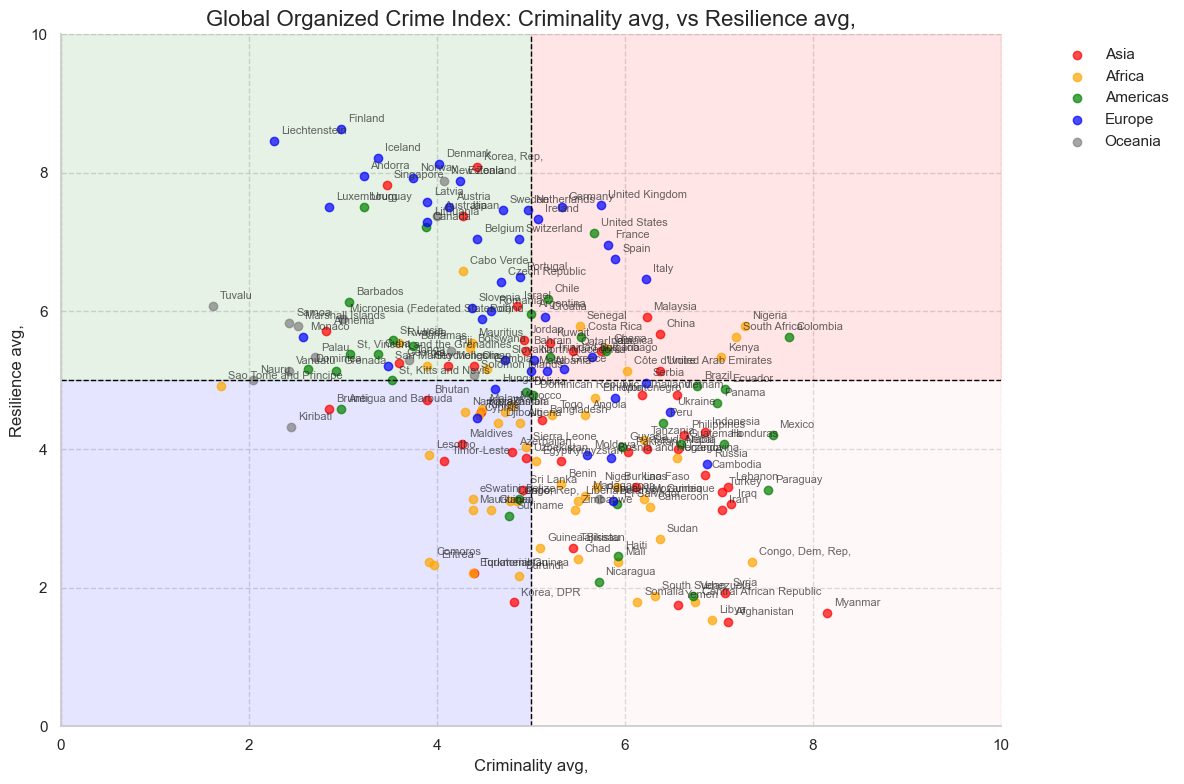

In [10]:
# %%
# jupyter: {'source_hidden': true}
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_crime_plot(file_path):
    """
    Create an interactive scatter plot with dropdown menus for selecting metrics
    
    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing the dataset
    """
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name='2023_dataset')
    
    # Get list of numeric columns for dropdowns
    exclude_cols = ['Country', 'Continent', 'Region']
    numeric_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Create dropdown widgets
    x_dropdown = widgets.Dropdown(
        options=numeric_cols,
        value='Criminality avg,',
        description='X-axis:',
        style={'description_width': 'initial'},
        layout={'width': 'auto'}
    )
    
    y_dropdown = widgets.Dropdown(
        options=numeric_cols,
        value='Resilience avg,',
        description='Y-axis:',
        style={'description_width': 'initial'},
        layout={'width': 'auto'}
    )
    
    def plot_scatter(x_metric, y_metric):
        """Create the scatter plot with the selected metrics"""
        plt.figure(figsize=(12, 8))
        
        # Color the quadrants
        plt.axvline(x=5, color='black', linestyle='--', linewidth=1)
        plt.axhline(y=5, color='black', linestyle='--', linewidth=1)
        
        # Fill quadrants with semi-transparent colors
        plt.fill_between([0, 5], 5, 10, color='green', alpha=0.1)  # Top-left
        plt.fill_between([5, 10], 5, 10, color='red', alpha=0.1)   # Top-right
        plt.fill_between([0, 5], 0, 5, color='blue', alpha=0.1)    # Bottom-left
        plt.fill_between([5, 10], 0, 5, color='pink', alpha=0.1)   # Bottom-right
        
        # Color mapping for continents
        continent_colors = {
            'Africa': 'orange',
            'Americas': 'green',
            'Asia': 'red',
            'Europe': 'blue',
            'Oceania': 'gray'
        }
        
        # Create scatter plot
        for continent in df['Continent'].unique():
            subset = df[df['Continent'] == continent]
            plt.scatter(subset[x_metric], subset[y_metric],
                      c=continent_colors[continent],
                      label=continent,
                      alpha=0.7)
        
        # Add country labels
        for _, row in df.iterrows():
            plt.annotate(row['Country'],
                        (row[x_metric], row[y_metric]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.7)
        
        # Customize the plot
        plt.title(f'Global Organized Crime Index: {x_metric} vs {y_metric}',
                 fontsize=16)
        plt.xlabel(x_metric, fontsize=12)
        plt.ylabel(y_metric, fontsize=12)
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def update_plot(*args):
        """Callback function to update the plot when dropdowns change"""
        clear_output(wait=True)
        # Display dropdowns
        display(widgets.HBox([x_dropdown, y_dropdown]))
        # Create new plot
        plot_scatter(x_dropdown.value, y_dropdown.value)
    
    # Set up the callback
    x_dropdown.observe(update_plot, 'value')
    y_dropdown.observe(update_plot, 'value')
    
    # Initial plot
    update_plot()

# Example usage
if __name__ == '__main__':
    file_path = os.path.join(data_dir, 'global_oc_index.xlsx')
    create_interactive_crime_plot(file_path)

# Demographics
## Projected WB Population
XX.

<Figure size 640x480 with 0 Axes>

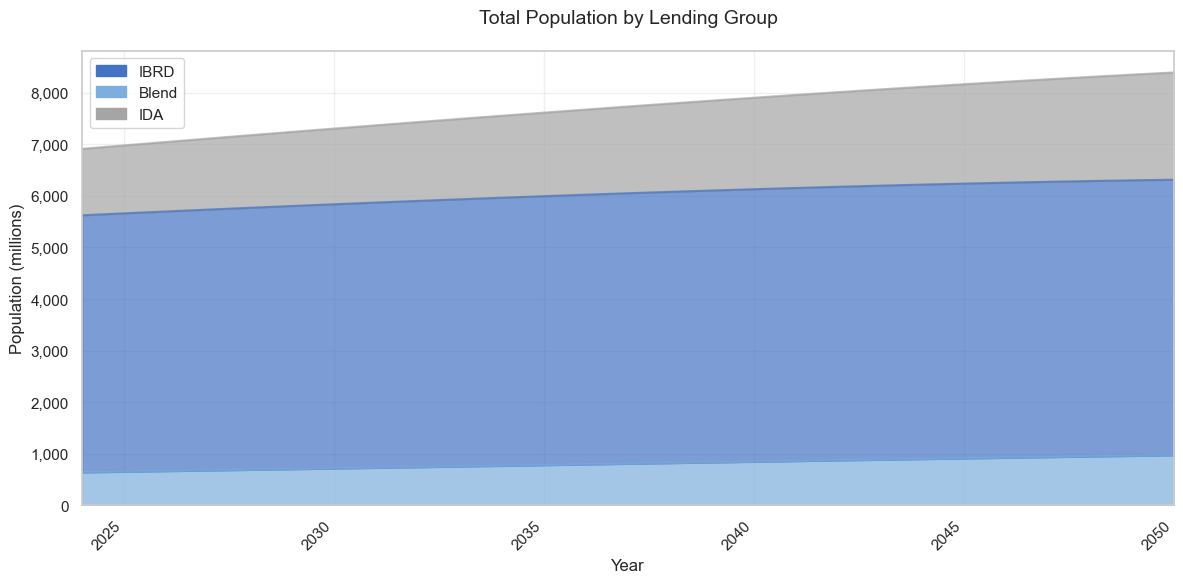

<Figure size 640x480 with 0 Axes>

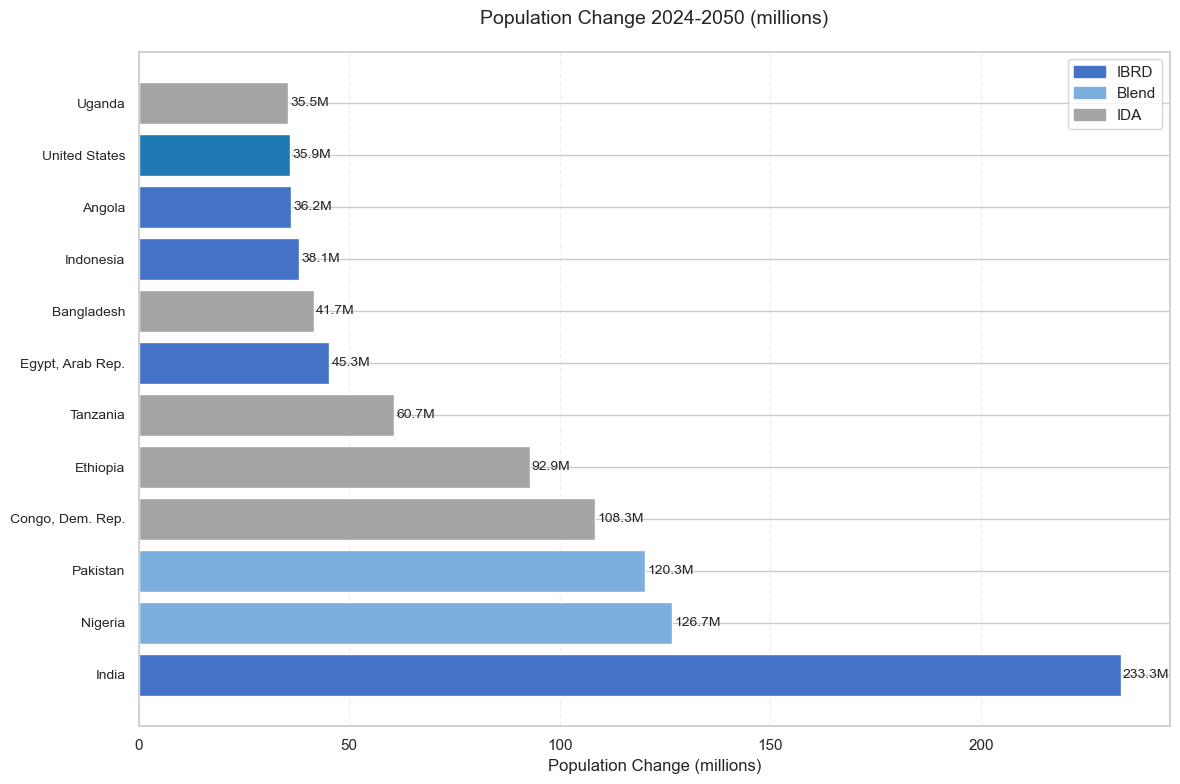

In [34]:
# %%
# jupyter: {'source_hidden': true}
# # Initialize the API client
# api_client = UNPopulationDataPortalAPI()

# # Test API connection
# if not api_client.test_api_connection():
#     logger.error("Unable to establish API connection.")
#     sys.exit(1)

# try:
#     # Retrieve country IDs
#     country_ids = api_client.get_country_ids()
#     logger.info(f"Total Countries Retrieved: {len(country_ids)}")
#     logger.info("First 10 Country IDs: %s", country_ids[:10])

# except Exception as e:
#     logger.error(f"An error occurred: {e}")

def plot_population_trends_by_lending(data_dir, end_year=2050):
    """
    Create stacked area chart of total population by lending group
    """
    # Read data
    file_path = os.path.join(data_dir, 'un_pop_data.xlsx')
    lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')
    
    df = pd.read_excel(file_path, sheet_name='Medium variant')
    lending_df = pd.read_excel(lend_group_path)
    
    # Process data
    df = df.dropna(subset=['ISO3 Alpha-code'])
    df['Total Population, as of 1 January (thousands)'] = pd.to_numeric(
        df['Total Population, as of 1 January (thousands)'], 
        errors='coerce'
    )
    
    # Merge with lending group data
    df = df.merge(lending_df[['Code', 'Lending category', 'Economy']], 
                 left_on='ISO3 Alpha-code', 
                 right_on='Code', 
                 how='left')
    
    # Clear previous plots
    plt.clf()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color mapping
    color_map = {
        'IBRD': '#4472C4',     # Royal blue
        'Blend': '#7CAFDD',    # Lighter blue
        'IDA': '#A5A5A5'       # Gray
    }
    
    # Create pivot table for stacked area
    lending_group_pop = df.pivot_table(
        index='Year',
        columns='Lending category',
        values='Total Population, as of 1 January (thousands)',
        aggfunc='sum'
    )
    
    # Filter data up to end_year
    lending_group_pop = lending_group_pop[lending_group_pop.index <= end_year]
    
    # Create stacked area plot
    lending_group_pop.plot(
        kind='area',
        stacked=True,
        ax=ax,
        color=[color_map.get(cat, '#1F77B4') for cat in lending_group_pop.columns],
        alpha=0.7
    )
    
    # Customize plot
    ax.set_xlim(lending_group_pop.index.min(), end_year)
    ax.set_title('Total Population by Lending Group', fontsize=14, pad=20)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Population (millions)', fontsize=12)
    
    # Format y-axis with millions
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000):,}'))
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
    labels = list(color_map.keys())
    ax.legend(handles, labels, loc='upper left')
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_population_change_by_country(data_dir, start_year=2024, top_n=12):
    """
    Create horizontal bar chart of population change by country
    """
    # Read data
    file_path = os.path.join(data_dir, 'un_pop_data.xlsx')
    lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')
    
    df = pd.read_excel(file_path, sheet_name='Medium variant')
    lending_df = pd.read_excel(lend_group_path)
    
    # Process data
    df = df.dropna(subset=['ISO3 Alpha-code'])
    df['Total Population, as of 1 January (thousands)'] = pd.to_numeric(
        df['Total Population, as of 1 January (thousands)'], 
        errors='coerce'
    )
    
    # Merge with lending group data
    df = df.merge(lending_df[['Code', 'Lending category', 'Economy']], 
                 left_on='ISO3 Alpha-code', 
                 right_on='Code', 
                 how='left')
    
    # Calculate population change
    pop_start = df[df['Year'] == start_year].set_index('ISO3 Alpha-code')['Total Population, as of 1 January (thousands)']
    pop_2050 = df[df['Year'] == 2050].set_index('ISO3 Alpha-code')['Total Population, as of 1 January (thousands)']
    pop_change = (pop_2050 - pop_start) / 1000  # Convert to millions
    
    # Add population change to 2050 data
    df_2050 = df[df['Year'] == 2050].copy()
    df_2050['Population Change (millions)'] = df_2050['ISO3 Alpha-code'].map(pop_change)
    
    # Clear previous plots
    plt.clf()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color mapping
    color_map = {
        'IBRD': '#4472C4',     # Royal blue
        'Blend': '#7CAFDD',    # Lighter blue
        'IDA': '#A5A5A5'       # Gray
    }
    
    # Get top changes
    top_changes = df_2050.nlargest(top_n, 'Population Change (millions)').sort_values('Population Change (millions)')
    
    # Create horizontal bar chart
    bars = ax.barh(
        range(len(top_changes)),
        top_changes['Population Change (millions)'],
        color=[color_map.get(cat, '#1F77B4') for cat in top_changes['Lending category']]
    )
    
    # Customize plot
    ax.invert_yaxis()
    ax.set_title(f'Population Change {start_year}-2050 (millions)', fontsize=14, pad=20)
    ax.set_xlabel('Population Change (millions)', fontsize=12)
    ax.set_yticks(range(len(top_changes)))
    ax.set_yticklabels(top_changes['Economy'], fontsize=10)
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5,                     # x position with offset
                bar.get_y() + bar.get_height()/2, # y position
                f'{width:,.1f}M',                 # text
                ha='left',                        # horizontal alignment
                va='center',                      # vertical alignment
                fontsize=10)                      # font size
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
    labels = list(color_map.keys())
    ax.legend(handles, labels, loc='upper right')
    
    # Add grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Create and display both plots
    plot_population_trends_by_lending(data_dir)
    plot_population_change_by_country(data_dir)

## Millions of Extreme Poor
XX.

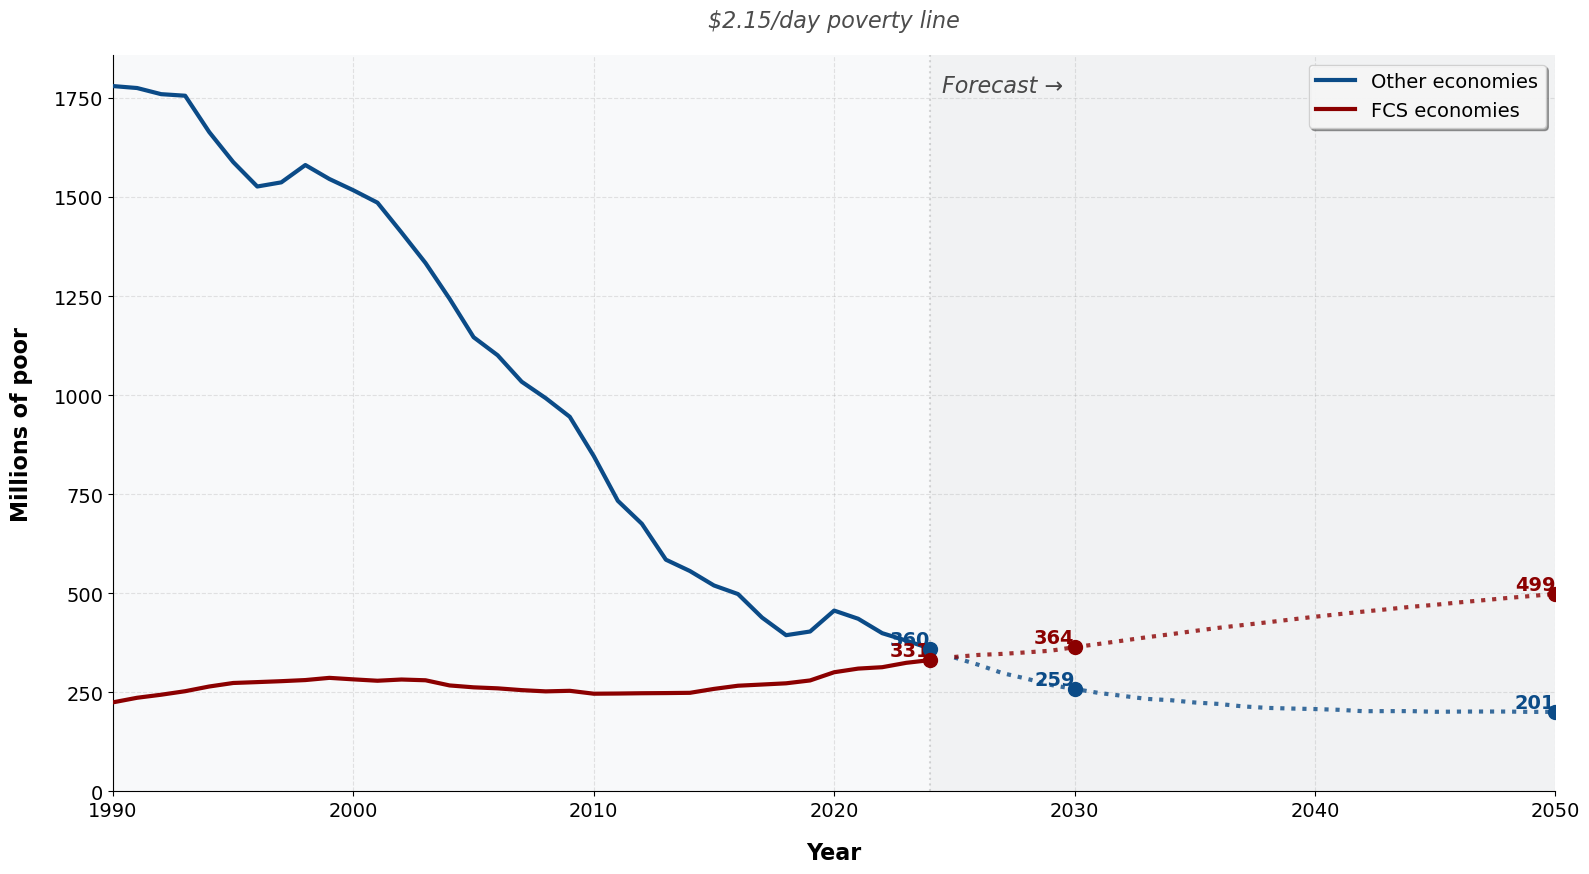

In [6]:
# Define FCS countries
FCS_COUNTRIES = [
    'Afghanistan', 'Burkina Faso', 'Cameroon', 'Central African Republic', 
    'Congo, Dem. Rep.', 'Ethiopia', 'Haiti', 'Iraq', 'Lebanon', 'Mali', 
    'Mozambique', 'Myanmar', 'Niger', 'Nigeria', 'Somalia', 'South Sudan',
    'Sudan', 'Syrian Arab Republic', 'Ukraine', 'West Bank and Gaza',
    'Yemen, Rep.', 'Burundi', 'Chad', 'Comoros', 'Congo, Rep.', 'Eritrea',
    'Guinea-Bissau', 'Kiribati', 'Kosovo', 'Libya', 'Marshall Islands',
    'Micronesia, Fed. Sts.', 'Papua New Guinea', 'São Tomé and Principe',
    'Solomon Islands', 'Timor-Leste', 'Tuvalu', 'Venezuela, RB', 'Zimbabwe'
]

def plot_poverty_trends(data_dir: str, output_path: str = None) -> None:
    """
    Create an enhanced plot showing poverty trends for FCS and other economies,
    with historical data and forecasts up to 2050.
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Read the data
    pip_path = os.path.join(data_dir, 'pip_forecast_2050.csv')
    df = pd.read_csv(pip_path)
    
    # Filter for $2.15 poverty line
    df = df[df['povertyline'] == 2.15].copy()
    
    # Create FCV grouping based on country list
    df['is_fcv'] = df['country'].isin(FCS_COUNTRIES).astype(int)
    
    # Aggregate poorpop by year and FCV status
    agg_df = df.groupby(['year', 'is_fcv'])['poorpop'].sum().reset_index()
    
    # Pivot the data for plotting
    plot_df = agg_df.pivot(index='year', columns='is_fcv', values='poorpop')
    plot_df.columns = ['Other economies', 'FCS economies']
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Define colors
    colors = ['#0B4B87', '#8B0000']  # Dark blue for others, Dark red for FCS
    
    # Historical data (up to 2024)
    historical = plot_df[plot_df.index <= 2024]
    forecast = plot_df[plot_df.index > 2024]
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Plot historical data (solid lines)
    for i, col in enumerate(plot_df.columns):
        ax.plot(historical.index, historical[col], 
               label=col, 
               linewidth=3.0,  # Increased line width
               color=colors[i],
               zorder=3)
    
    # Plot forecast data (dashed lines)
    for i, col in enumerate(plot_df.columns):
        ax.plot(forecast.index, forecast[col], 
               linestyle=':', 
               linewidth=3.0,  # Increased line width
               color=colors[i],
               alpha=0.8,
               zorder=3)
        
        # Add data points for key years
        for year in [2024, 2030, 2050]:
            if year in plot_df.index:
                ax.scatter(year, plot_df.loc[year, col], 
                          color=colors[i], s=100,  # Increased point size
                          zorder=4)
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=14)  # Increased tick label size
    
    # Add labels
    ax.set_xlabel('Year', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    ax.set_ylabel('Millions of poor', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    
    # Set axis limits
    ax.set_ylim(bottom=0)
    ax.set_xlim(1990, 2050)
    
    # Add title and subtitle
    plt.suptitle('', 
                 fontsize=20, fontweight='bold', y=0.95)  # Increased title size
    plt.title('$2.15/day poverty line',
             fontsize=16, style='italic', alpha=0.7, pad=20)  # Increased subtitle size
    
    # Add legend inside the plot with larger text
    legend = ax.legend(ncol=1, loc='upper right',
                      frameon=True, fancybox=True, shadow=True,
                      fontsize=14)  # Increased legend font size
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Add forecast annotation with larger text
    ax.axvline(x=2024, color='gray', linestyle=':', alpha=0.3, zorder=2)
    ax.text(2024.5, ax.get_ylim()[1]*0.95, 'Forecast →', 
            fontsize=16, alpha=0.7,  # Increased annotation size
            style='italic')
    
    # Add shaded forecast area
    forecast_shade = patches.Rectangle((2024, 0), 26, ax.get_ylim()[1],
                                     facecolor='gray', alpha=0.05,
                                     zorder=1)
    ax.add_patch(forecast_shade)
    
    # Add data labels for key years with larger text
    for i, col in enumerate(plot_df.columns):
        for year in [2024, 2030, 2050]:
            if year in plot_df.index:
                value = plot_df.loc[year, col]
                ax.text(year, value, f'{value:.0f}', 
                       color=colors[i], fontweight='bold',
                       fontsize=14,  # Increased label size
                       ha='right', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or display
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    plt.close()

plot_poverty_trends(data_dir)

## Millions of poor, by poverty line, in FCS and non-FCS
XX.

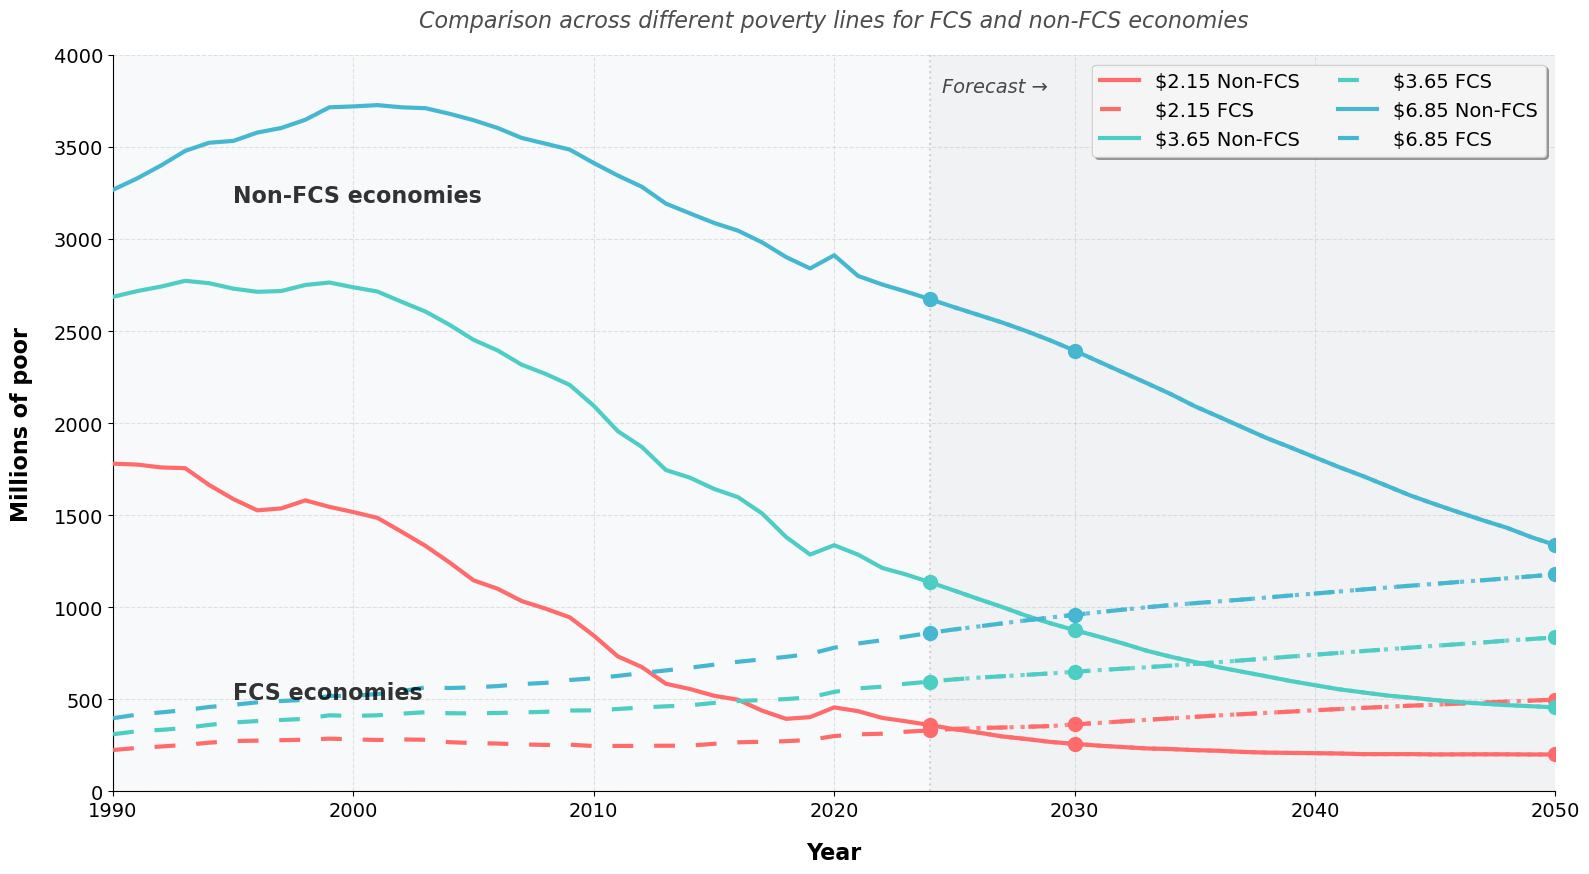

In [31]:
def plot_poverty_trends_all(data_dir: str, output_path: str = None) -> None:
    """
    Create an enhanced plot showing poverty trends for FCS and non-FCS economies 
    across all poverty lines, with historical data and forecasts up to 2050.
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Read the data
    pip_path = os.path.join(data_dir, 'pip_forecast_2050.csv')
    df = pd.read_csv(pip_path)
    
    # Create FCV grouping based on country list
    df['is_fcv'] = df['country'].isin(FCS_COUNTRIES).astype(int)
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Define colors
    colors = {
        2.15: '#FF6B6B',
        3.65: '#4ECDC4',
        6.85: '#45B7D1'
    }
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Process each poverty line
    for pline in [2.15, 3.65, 6.85]:
        df_pline = df[df['povertyline'] == pline].copy()
        agg_df = df_pline.groupby(['year', 'is_fcv'])['poorpop'].sum().reset_index()
        
        # Plot for non-FCS
        non_fcs = agg_df[agg_df['is_fcv'] == 0]
        ax.plot(non_fcs['year'], non_fcs['poorpop'], 
                color=colors[pline], 
                label=f'${pline:.2f} Non-FCS',
                linewidth=3.0,  # Increased line width
                zorder=3)
        
        # Plot for FCS
        fcs = agg_df[agg_df['is_fcv'] == 1]
        ax.plot(fcs['year'], fcs['poorpop'], 
                color=colors[pline],
                linestyle=(0, (5, 5)),
                label=f'${pline:.2f} FCS',
                linewidth=3.0,  # Increased line width
                zorder=3)
        
        # Add forecast parts
        non_fcs_forecast = non_fcs[non_fcs['year'] > 2024]
        fcs_forecast = fcs[fcs['year'] > 2024]
        
        ax.plot(non_fcs_forecast['year'], non_fcs_forecast['poorpop'],
                color=colors[pline], linestyle=':', linewidth=3.0, alpha=0.8, zorder=3)
        ax.plot(fcs_forecast['year'], fcs_forecast['poorpop'],
                color=colors[pline], linestyle=':', linewidth=3.0, alpha=0.8, zorder=3)
        
        # Add data points for 2024 and 2030
        for year in [2024, 2030, 2050]:
            if year in non_fcs['year'].values:
                ax.scatter(year, non_fcs[non_fcs['year'] == year]['poorpop'].values[0], 
                          color=colors[pline], s=100, zorder=4)  # Increased point size
                ax.scatter(year, fcs[fcs['year'] == year]['poorpop'].values[0], 
                          color=colors[pline], s=100, zorder=4)  # Increased point size
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=14)  # Increased tick label size
    
    # Add labels
    ax.set_xlabel('Year', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    ax.set_ylabel('Millions of poor', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    
    # Set axis limits
    ax.set_ylim(bottom=0, top=4000)
    ax.set_xlim(1990, 2050)
    
    # Add title and subtitle
    plt.suptitle('', 
                 fontsize=20, fontweight='bold', y=0.95)  # Increased title size
    plt.title('Comparison across different poverty lines for FCS and non-FCS economies',
             fontsize=16, style='italic', alpha=0.7, pad=20)  # Increased subtitle size
    
    # Create legend with larger text
    legend = ax.legend(ncol=2, loc='upper right',
                      frameon=True, fancybox=True, shadow=True,
                      fontsize=14)  # Increased legend font size
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Add forecast annotation with larger text
    ax.axvline(x=2024, color='gray', linestyle=':', alpha=0.3, zorder=2)
    ax.text(2024.5, 3800, 'Forecast →', 
            fontsize=14, alpha=0.7,  # Increased annotation size
            style='italic')
    
    # Add shaded forecast area
    forecast_shade = patches.Rectangle((2024, 0), 26, 4000,
                                     facecolor='gray', alpha=0.05,
                                     zorder=1)
    ax.add_patch(forecast_shade)
    
    # Add annotations for key groups with larger text
    ax.text(1995, 3200, 'Non-FCS economies', 
            fontsize=16, fontweight='bold', alpha=0.8)  # Increased text size
    ax.text(1995, 500, 'FCS economies', 
            fontsize=16, fontweight='bold', alpha=0.8)  # Increased text size
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or display with higher DPI
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    plt.close()


plot_poverty_trends_all(data_dir)

# Development Indicators and FCV
## Mortality rate, under 5 (per 1,000 live births)
XX.

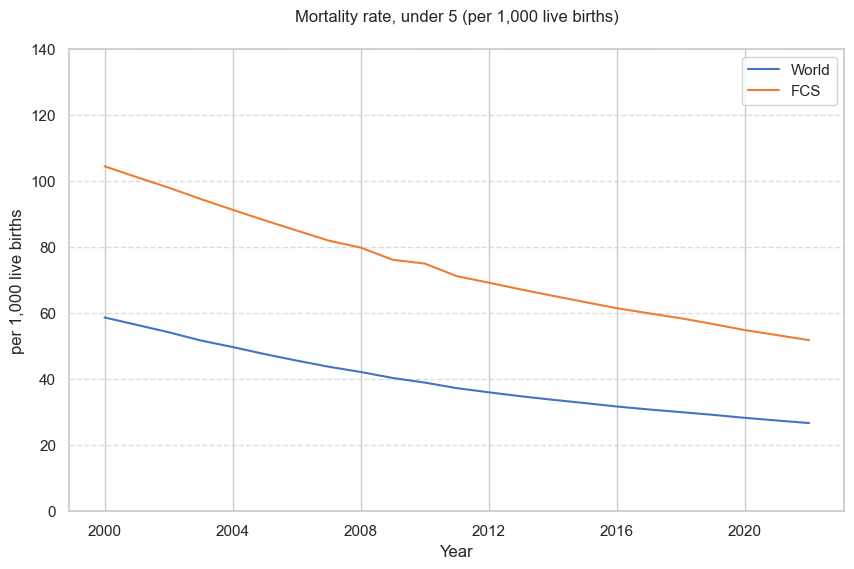

In [ ]:
# %%
# jupyter: {'source_hidden': true}
def get_country_averages(wb_data, countries=None):
    """Helper function to calculate averages for a group of countries"""
    df = pd.DataFrame(wb_data)
    if countries:
        df = df[df['country'].isin(countries)]
    return df.groupby('date')['SH.DYN.MORT'].mean()

def plot_mortality_rate(wb_data):
    """
    Plot under-5 mortality rate
    Indicator: SH.DYN.MORT
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data for plotting
    df = pd.DataFrame(wb_data)
    
    # Calculate world average (using all countries)
    world_data = get_country_averages(wb_data)
    
    # Calculate FCS average
    fcs_data = get_country_averages(wb_data, FCS_COUNTRIES)
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('Mortality rate, under 5 (per 1,000 live births)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('per 1,000 live births')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    
    # Adjust y-axis range
    ax.set_ylim(0, 140)
    
    return fig


mortality_data = wb.get_indicator_data(indicator='SH.DYN.MORT', start_year=2000, end_year=2024)
fig = plot_mortality_rate(mortality_data)
plt.show()

## Primary completion rate, total (% of relevant age group)
XX.

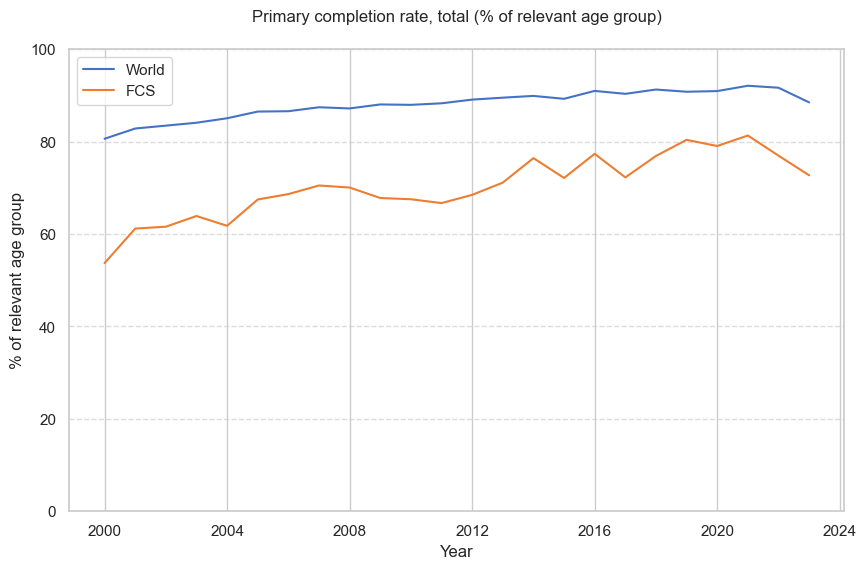

In [9]:
# %%
# jupyter: {'source_hidden': true}
def plot_primary_completion(wb_data):
    """
    Plot primary completion rate
    Indicator: SE.PRM.CMPT.ZS
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data
    df = pd.DataFrame(wb_data)
    
    # Calculate averages
    world_data = df.groupby('date')['SE.PRM.CMPT.ZS'].mean()
    fcs_data = df[df['country'].isin(FCS_COUNTRIES)].groupby('date')['SE.PRM.CMPT.ZS'].mean()
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('Primary completion rate, total (% of relevant age group)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('% of relevant age group')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 100)
    
    return fig

# Get data and plot
primary_data = wb.get_indicator_data(indicator='SE.PRM.CMPT.ZS', start_year=2000, end_year=2024)
fig = plot_primary_completion(primary_data)
plt.show()

## People using at least basic sanitation services (% of population)
XX.

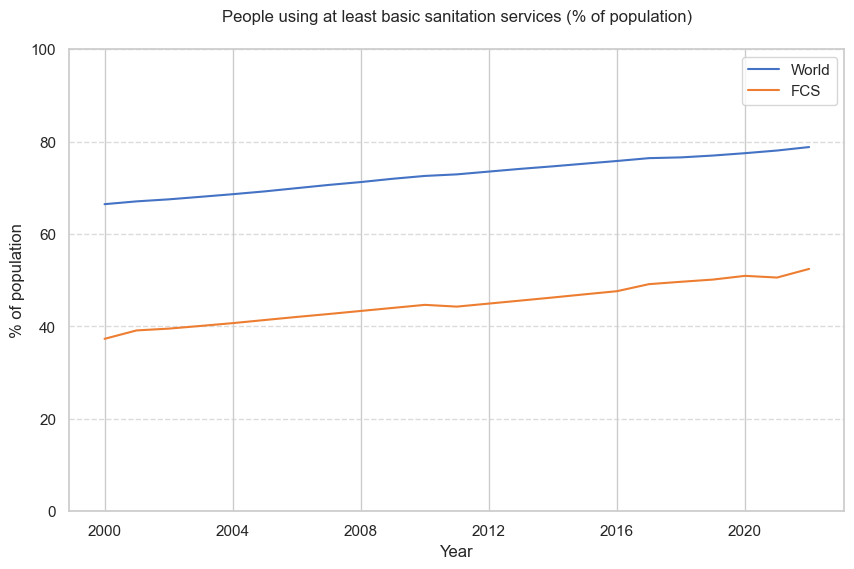

In [11]:
# %%
# jupyter: {'source_hidden': true}
def plot_sanitation(wb_data):
    """
    Plot basic sanitation services
    Indicator: SH.STA.BASS.ZS
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data
    df = pd.DataFrame(wb_data)
    
    # Calculate averages
    world_data = df.groupby('date')['SH.STA.BASS.ZS'].mean()
    fcs_data = df[df['country'].isin(FCS_COUNTRIES)].groupby('date')['SH.STA.BASS.ZS'].mean()
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('People using at least basic sanitation services (% of population)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('% of population')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 100)
    
    return fig

# Get data and plot
sanitation_data = wb.get_indicator_data(indicator='SH.STA.BASS.ZS', start_year=2000, end_year=2024)
fig = plot_sanitation(sanitation_data)
plt.show()

## People using at least basic drinking water services (% of population)
XX. 

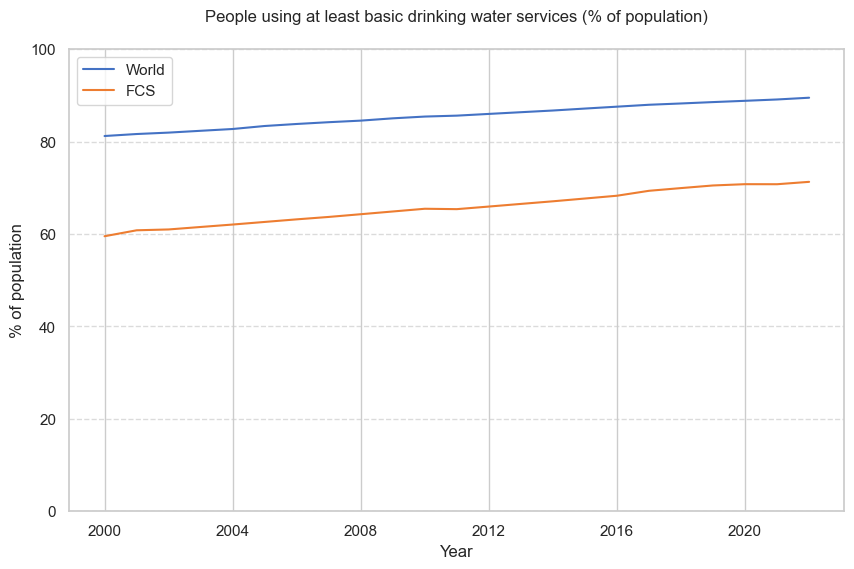

In [12]:
# %%
# jupyter: {'source_hidden': true}
def plot_water_services(wb_data):
    """
    Plot basic drinking water services
    Indicator: SH.H2O.BASW.ZS
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data
    df = pd.DataFrame(wb_data)
    
    # Calculate averages
    world_data = df.groupby('date')['SH.H2O.BASW.ZS'].mean()
    fcs_data = df[df['country'].isin(FCS_COUNTRIES)].groupby('date')['SH.H2O.BASW.ZS'].mean()
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('People using at least basic drinking water services (% of population)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('% of population')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 100)
    
    return fig

# Get data and plot
water_data = wb.get_indicator_data(indicator='SH.H2O.BASW.ZS', start_year=2000, end_year=2024)
fig = plot_water_services(water_data)
plt.show()

# Fragility
## States of Fragility 2022
XX.

In [14]:
import os
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

def create_interactive_fragility_plot(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name='Scores')
    
    # Clean column names by removing 'PC1'
    df.columns = [col.replace('.PC1', '') for col in df.columns]
    
    # Get list of numeric columns for dropdowns
    exclude_cols = ['iso3c', 'country', 'type']
    numeric_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Create base figure
    fig = go.Figure()

    # Add scatter trace
    fig.add_trace(go.Scatter(
        x=df['Aggregate'], 
        y=df['Political'],
        mode='markers',
        text=df['country'],
        hoverinfo='text+x+y',
        marker=dict(
            color=df['type'].map({
                'Extremely fragile': 'red',
                'Other fragile': 'orange',
                'Rest of the world': 'gray'
            }),
            size=10,
            opacity=0.7
        )
    ))

    # Update layout
    fig.update_layout(
        title='States of Fragility 2022: Aggregate vs Political',
        xaxis_title='Aggregate',
        yaxis_title='Political',
        height=600,
        width=1000,
        updatemenus=[
            # X-axis dropdown
            dict(
                buttons=list([
                    dict(
                        args=[{'x': [df[col]]}],
                        label=col,
                        method='restyle'
                    ) for col in numeric_cols
                ]),
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
            # Y-axis dropdown
            dict(
                buttons=list([
                    dict(
                        args=[{'y': [df[col]]}],
                        label=col,
                        method='restyle'
                    ) for col in numeric_cols
                ]),
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.3,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ]
    )

    # Add axis labels to dropdowns
    fig.update_layout(
        annotations=[
            dict(text="X-axis:", x=0, xref="paper", y=1.15, yref="paper", align="left", showarrow=False),
            dict(text="Y-axis:", x=0.2, xref="paper", y=1.15, yref="paper", align="left", showarrow=False)
        ]
    )

    return fig

# Usage
file_path = os.path.join(data_dir, 'sof_2022.xlsx')
fig = create_interactive_fragility_plot(file_path)
fig.show()


# Maps
## FCS Map - FY25
XX.

In [15]:
import plotly.express as px
import pandas as pd

def create_fcs_classification_map():
    """
    Create a choropleth map visualizing Fragile and Conflict-Affected Situations (FCS) classification.
    
    Returns:
    plotly.graph_objects.Figure: A choropleth map showing countries classified by their FCS status
    """
    # Expanded country list including Greenland
    all_countries = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda",
        "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
        "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina",
        "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia",
        "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros",
        "Congo, Dem. Rep.", "Congo, Rep.", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Cyprus",
        "Czech Republic", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", "Finland",
        "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala",
        "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia",
        "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya",
        "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya",
        "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali",
        "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova",
        "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal",
        "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Korea", "North Macedonia",
        "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea", "Paraguay", "Peru",
        "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis",
        "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia",
        "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Korea", "South Sudan", "Spain",
        "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan", "Tanzania",
        "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom",
        "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City", "Venezuela", "Vietnam",
        "Yemen", "Zambia", "Zimbabwe", "Greenland"
    ]

    # Define FCS categories
    conflict_countries = [
        "Afghanistan", "Burkina Faso", "Cameroon", "Central African Republic", "Congo, Dem. Rep.",
        "Ethiopia", "Haiti", "Iraq", "Lebanon", "Mali", "Mozambique", "Myanmar", "Niger", "Nigeria",
        "Somalia", "Sudan", "Syria", "Ukraine", "West Bank and Gaza", "Yemen"
    ]

    institutional_fragility = [
        "Burundi", "Chad", "Comoros", "Congo, Rep.", "Eritrea", "Guinea-Bissau", "Libya",
        "Sao Tome and Principe", "Venezuela", "Zimbabwe"
    ]

    # Assign classification
    df = pd.DataFrame({"country": all_countries})
    df["status"] = "Rest of the world"
    df.loc[df["country"].isin(conflict_countries), "status"] = "Conflict"
    df.loc[df["country"].isin(institutional_fragility), "status"] = "Institutional Fragility"

    # Define a categorical order for legend
    df["status"] = pd.Categorical(
        df["status"],
        categories=["Conflict", "Institutional Fragility", "Rest of the world"],
        ordered=True
    )

    # Define colors
    color_discrete_map = {
        "Conflict": "#B22222",  # Dark red
        "Institutional Fragility": "#DAA520",  # Goldenrod
        "Rest of the world": "#C0C0C0"  # Light gray
    }

    # Create figure
    fig = px.choropleth(
        df,
        locations="country",
        locationmode="country names",
        color="status",
        category_orders={"status": ["Conflict", "Institutional Fragility", "Rest of the world"]},  # Enforce order
        color_discrete_map=color_discrete_map,
        scope="world",
        labels={"status": "FCS Classification"},
        height=600
    )

    # Update layout
    fig.update_layout(
        margin=dict(t=0, b=0, l=0, r=0),
        paper_bgcolor="white",
        plot_bgcolor="white",
        showlegend=True,
        legend=dict(
            x=0.02,
            y=0.10,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="gray",
            borderwidth=1,
            title="FCS Classification - FY25"
        )
    )

    # Order the legend
    fig.update_layout(legend=dict(traceorder="normal"))

    # Remove Antarctica & Zoom
    fig.update_geos(
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        showframe=False,
        showocean=True,
        oceancolor="white",
        projection_type="equirectangular",
        showcountries=True,
        countrycolor="gray",
        countrywidth=0.5,
        showlakes=True,
        lakecolor="white",
        lataxis_range=[-60, 80],  # Exclude Antarctica
        lonaxis_range=[-180, 180],  # Full longitude range
        resolution=110
    )

    return fig


map_fig = create_fcs_classification_map()
map_fig.show()

# Structural Factors [PLACEHOLDER FOR SLOW MOVING FACTORS]